In [231]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [232]:
%matplotlib inline


In [233]:
df = pd.read_csv('merge_train.csv',parse_dates=['date'])

In [234]:
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekdays'] = df['date'].dt.dayofweek  # 1 for weekend, 0 for weekday
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
# df['EMA_4h'] = df['Price'].ewm(span=48, adjust=False).mean()


df['SMA_4h'] = df['Price'].shift(1).rolling(window=48).mean()

df['SMA_1h'] = df['Price'].shift(1).rolling(window=12).mean()

df['SMA_30min'] = df['Price'].shift(1).rolling(window=6).mean()


df['SMA_2h'] = df['Price'].shift(1).rolling(window=24).mean()


df["Dmemand_diff"] = df["Demand"] - df["Actual_Demand_OPERATIONAL_DEMAND"]
# df['EMA_1d'] = df['Price'].ewm(span=288, adjust=False).mean()
df['Forecast_difference_0.5 hour future'] = df['Forecast_Roof_0.5 hour future'] - df['Forecast_Demand_0.5 hour future']
df["Forecast_ratio_0.5 hour future"] = df['Forecast_Roof_0.5 hour future'] / df['Forecast_Demand_0.5 hour future']

df.set_index('date', inplace=True)

In [235]:

def mark_peak_hours(hour):
    if (8 <= hour < 10) or (15 <= hour < 17):
        return 1 
    else:
        return 0  


df['is_peak_hour'] = df['hour'].apply(mark_peak_hours)


In [236]:

df = df.drop(columns=['Region', 'Actual_Roof_OPOWER', 'Actual_Roof_LASTCHANGED','Adjusted_Actual_Roof_OPOWER'])
# df = df.drop(df.columns[df.columns.str.contains('forecast', case=False)], axis=1)



In [237]:
df.columns


Index(['Demand', 'Price', 'Forecast_Demand_0.5 hour future',
       'Forecast_Demand_1 hour future', 'Forecast_Demand_1.5 hours future',
       'Forecast_Demand_2 hours future', 'Forecast_Demand_2.5 hours future',
       'Forecast_Demand_3 hours future', 'Forecast_Demand_3.5 hours future',
       'Forecast_Demand_4 hours future', 'Forecast_Demand_4.5 hours future',
       'Forecast_Demand_5 hours future', 'Forecast_Demand_5.5 hours future',
       'Forecast_Demand_6 hours future', 'Forecast_Demand_6.5 hours future',
       'Forecast_Demand_7 hours future', 'Forecast_Demand_7.5 hours future',
       'Forecast_Demand_8 hours future', 'Forecast_Demand_8.5 hours future',
       'Forecast_Demand_9 hours future', 'Forecast_Demand_9.5 hours future',
       'Forecast_Roof_0.5 hour future', 'Forecast_Roof_1 hour future',
       'Forecast_Roof_1.5 hours future', 'Forecast_Roof_2 hours future',
       'Forecast_Roof_2.5 hours future', 'Forecast_Roof_3 hours future',
       'Forecast_Roof_3.5 hour

In [238]:
from datetime import datetime, time

def create_qld_holidays_list():
    holidays = [
        # 2023
        "2023-01-01", "2023-01-02", "2023-01-26", "2023-04-07", "2023-04-08", "2023-04-09", "2023-04-10",
        "2023-04-25", "2023-05-01", "2023-08-16", "2023-10-02", "2023-12-25", "2023-12-26",
        # 2024
        "2024-01-01", "2024-01-26", "2024-03-29", "2024-03-30", "2024-03-31", "2024-04-01",
        "2024-04-25", "2024-05-06", "2024-08-14", "2024-10-07", "2024-12-25", "2024-12-26",
        # 2025
        "2025-01-01", "2025-01-27", "2025-04-18", "2025-04-19", "2025-04-20", "2025-04-21",
        "2025-04-25", "2025-05-05", "2025-08-13", "2025-10-06", "2025-12-25", "2025-12-26"
    ]
    return pd.to_datetime(holidays)

def add_qld_holidays(df):
    holidays = create_qld_holidays_list()
    
   
    df['is_holiday'] = 0
    
    df.loc[df.index.isin(holidays), 'is_holiday'] = 1
    
    
    return df

In [239]:
df = add_qld_holidays(df)

In [240]:
df.columns

Index(['Demand', 'Price', 'Forecast_Demand_0.5 hour future',
       'Forecast_Demand_1 hour future', 'Forecast_Demand_1.5 hours future',
       'Forecast_Demand_2 hours future', 'Forecast_Demand_2.5 hours future',
       'Forecast_Demand_3 hours future', 'Forecast_Demand_3.5 hours future',
       'Forecast_Demand_4 hours future', 'Forecast_Demand_4.5 hours future',
       'Forecast_Demand_5 hours future', 'Forecast_Demand_5.5 hours future',
       'Forecast_Demand_6 hours future', 'Forecast_Demand_6.5 hours future',
       'Forecast_Demand_7 hours future', 'Forecast_Demand_7.5 hours future',
       'Forecast_Demand_8 hours future', 'Forecast_Demand_8.5 hours future',
       'Forecast_Demand_9 hours future', 'Forecast_Demand_9.5 hours future',
       'Forecast_Roof_0.5 hour future', 'Forecast_Roof_1 hour future',
       'Forecast_Roof_1.5 hours future', 'Forecast_Roof_2 hours future',
       'Forecast_Roof_2.5 hours future', 'Forecast_Roof_3 hours future',
       'Forecast_Roof_3.5 hour

In [241]:
df

,Demand,Price,Forecast_Demand_0.5 hour future,Forecast_Demand_1 hour future,Forecast_Demand_1.5 hours future,Forecast_Demand_2 hours future,Forecast_Demand_2.5 hours future,Forecast_Demand_3 hours future,Forecast_Demand_3.5 hours future,Forecast_Demand_4 hours future,...,minute,SMA_4h,SMA_1h,SMA_30min,SMA_2h,Dmemand_diff,Forecast_difference_0.5 hour future,Forecast_ratio_0.5 hour future,is_peak_hour,is_holiday
date,,,,,,,,,,,,,,,,,,,,,
2023-07-23 00:00:00,5988.16,75.93,5874.0,5718.0,5608.0,5517.0,5450.0,5407.0,5391.0,5390.0,...,0,NaN,NaN,NaN,NaN,-68.84,-5874.0,0.0,0,0
2023-07-23 00:05:00,6002.58,151.76,5874.0,5718.0,5608.0,5517.0,5450.0,5407.0,5391.0,5390.0,...,5,NaN,NaN,NaN,NaN,-54.42,-5874.0,0.0,0,0
2023-07-23 00:10:00,5918.29,95.11,5874.0,5718.0,5608.0,5517.0,5450.0,5407.0,5391.0,5390.0,...,10,NaN,NaN,NaN,NaN,-138.71,-5874.0,0.0,0,0
2023-07-23 00:15:00,5930.99,95.74,5874.0,5718.0,5608.0,5517.0,5450.0,5407.0,5391.0,5390.0,...,15,NaN,NaN,NaN,NaN,-126.01,-5874.0,0.0,0,0
2023-07-23 00:20:00,5836.53,94.39,5874.0,5718.0,5608.0,5517.0,5450.0,5407.0,5391.0,5390.0,...,20,NaN,NaN,NaN,NaN,-220.47,-5874.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-03 22:40:00,6382.92,284.95,6535.0,6381.0,6210.0,6051.0,5904.0,5791.0,5705.0,5640.0,...,40,279.830000,257.741667,284.983333,264.400417,-315.08,-6535.0,0.0,0,0
2024-08-03 22:45:00,6378.81,284.97,6535.0,6381.0,6210.0,6051.0,5904.0,5791.0,5705.0,5640.0,...,45,279.629375,261.908333,284.671667,264.131250,-319.19,-6535.0,0.0,0,0
2024-08-03 22:50:00,6403.51,228.01,6535.0,6381.0,6210.0,6051.0,5904.0,5791.0,5705.0,5640.0,...,50,279.352500,262.394167,283.460000,263.902083,-294.49,-6535.0,0.0,0,0


In [242]:
df['Demand_lag'] = df['Demand'].shift(1)  
df['Actual_Demand_OPERATIONAL_DEMAND_lag'] = df['Actual_Demand_OPERATIONAL_DEMAND'].shift(1)
df['last_price'] = df['Price'].shift(1)
df['rolling_max_price'] = df['last_price'].rolling(window=24).max()
df['rolling_min_price'] = df['last_price'].rolling(window=24).min()

df['peak_hour_demand_lag'] = df['is_peak_hour'] * df['Demand_lag']
df['near_max'] = (df['last_price'] > (df['rolling_max_price'] * 0.9)).astype(int)
df['near_min'] = (df['last_price'] < (df['rolling_min_price'] * 1.1)).astype(int)


df.dropna(inplace=True)

In [243]:
df.columns

Index(['Demand', 'Price', 'Forecast_Demand_0.5 hour future',
       'Forecast_Demand_1 hour future', 'Forecast_Demand_1.5 hours future',
       'Forecast_Demand_2 hours future', 'Forecast_Demand_2.5 hours future',
       'Forecast_Demand_3 hours future', 'Forecast_Demand_3.5 hours future',
       'Forecast_Demand_4 hours future', 'Forecast_Demand_4.5 hours future',
       'Forecast_Demand_5 hours future', 'Forecast_Demand_5.5 hours future',
       'Forecast_Demand_6 hours future', 'Forecast_Demand_6.5 hours future',
       'Forecast_Demand_7 hours future', 'Forecast_Demand_7.5 hours future',
       'Forecast_Demand_8 hours future', 'Forecast_Demand_8.5 hours future',
       'Forecast_Demand_9 hours future', 'Forecast_Demand_9.5 hours future',
       'Forecast_Roof_0.5 hour future', 'Forecast_Roof_1 hour future',
       'Forecast_Roof_1.5 hours future', 'Forecast_Roof_2 hours future',
       'Forecast_Roof_2.5 hours future', 'Forecast_Roof_3 hours future',
       'Forecast_Roof_3.5 hour

In [244]:
for feature in df.columns:
    
    df[f'{feature}_shift_1'] = df[feature].shift(1)
    df[f'{feature}_shift_2'] = df[feature].shift(2)
    df[f'{feature}_shift_3'] = df[feature].shift(3)
    df[f'{feature}_shift_4'] = df[feature].shift(4)
    df[f'{feature}_shift_5'] = df[feature].shift(5)
    df[f'{feature}_shift_6'] = df[feature].shift(6)
df = df.dropna()
df = df.drop(['Demand', 'Actual_Demand_OPERATIONAL_DEMAND'], axis=1)

C:\Users\Owner\AppData\Local\Temp\ipykernel_12276\609747635.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_shift_3'] = df[feature].shift(3)
C:\Users\Owner\AppData\Local\Temp\ipykernel_12276\609747635.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_shift_4'] = df[feature].shift(4)
C:\Users\Owner\AppData\Local\Temp\ipykernel_12276\609747635.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  C

In [245]:
X = df.drop('Price', axis=1)
y = df['Price']

train_end_date = pd.to_datetime("2024-04-30 23:59:59")
val_end_date = pd.to_datetime("2024-05-31 23:59:59")
test_start_date = pd.to_datetime("2024-06-01 00:00:00")


X_train = X[X.index <= train_end_date]
X_val = X[(X.index > train_end_date) & (X.index <= val_end_date)]
X_test = X[X.index >= test_start_date]

y_train = y[y.index <= train_end_date]
y_val = y[(y.index > train_end_date) & (y.index <= val_end_date)]
y_test = y[y.index >= test_start_date]

In [246]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
class MultiLossXGBoostElectricityPrice:
    def __init__(self, alpha: float = 0.5, beta: float = 0.3, gamma: float = 0.2):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def custom_objective(self, preds: np.ndarray, dtrain: xgb.DMatrix):
        labels = dtrain.get_label()
        
        # MSE gradient and hessian
        grad_mse = preds - labels
        hess_mse = np.ones_like(preds)
        
        # MAE gradient and hessian
        grad_mae = np.sign(preds - labels)
        hess_mae = np.ones_like(preds) * 1e-6
        
        # Huber loss gradient and hessian (delta = 1)
        delta = 1
        diff = preds - labels
        grad_huber = np.where(np.abs(diff) <= delta, diff, delta * np.sign(diff))
        hess_huber = np.where(np.abs(diff) <= delta, 1, 0)
        
        # Combine gradients and hessians
        grad = self.alpha * grad_mse + self.beta * grad_mae + self.gamma * grad_huber
        hess = self.alpha * hess_mse + self.beta * hess_mae + self.gamma * hess_huber
        
        return grad, hess

    def custom_metric(self, preds: np.ndarray, dtrain: xgb.DMatrix):
        labels = dtrain.get_label()
        
        mse = mean_squared_error(labels, preds)
        mae = mean_absolute_error(labels, preds)
        huber = np.mean(np.where(np.abs(preds - labels) <= 5, 
                                 0.5 * (preds - labels)**2, 
                                 np.abs(preds - labels) - 0.5))
        
        combined_metric = self.alpha * mse + self.beta * mae + self.gamma * huber
        
        return 'combined_metric', combined_metric

    def train(self, X_train: pd.DataFrame, y_train: pd.Series, X_val: pd.DataFrame, y_val: pd.Series) -> xgb.Booster:
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)
        
        params = {
            'objective': 'reg:squarederror',
            'max_depth': 12,
            'learning_rate': 0.02,
            'min_child_weight':0.7,
            "lambda":0.8,
            'random_state': 42
        }
        
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=1000,
            evals=[(dtrain, 'train'), (dval, 'val')],
            obj=self.custom_objective,
            custom_metric=self.custom_metric,
            early_stopping_rounds=50,
            verbose_eval=100
        )
        
        return model

In [247]:
multi_loss_xgb = MultiLossXGBoostElectricityPrice(alpha=0.3, beta=0.4, gamma=0.3)
model = multi_loss_xgb.train(X_train, y_train, X_val, y_val)

[0]	train-rmse:403.68885	train-combined_metric:48953.13058	val-rmse:123.31735	val-combined_metric:4632.29333
[100]	train-rmse:147.53561	train-combined_metric:6543.11519	val-rmse:48.28659	val-combined_metric:714.80310
[137]	train-rmse:114.25004	train-combined_metric:3926.33927	val-rmse:49.89687	val-combined_metric:760.15681


In [248]:
dtest = xgb.DMatrix(X_test)
y_pred = model.predict(dtest)

In [249]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

Mean Squared Error: 79966.75091384849
Mean Absolute Error: 42.864633870595775
Root Mean Squared Error: 282.78392973054264


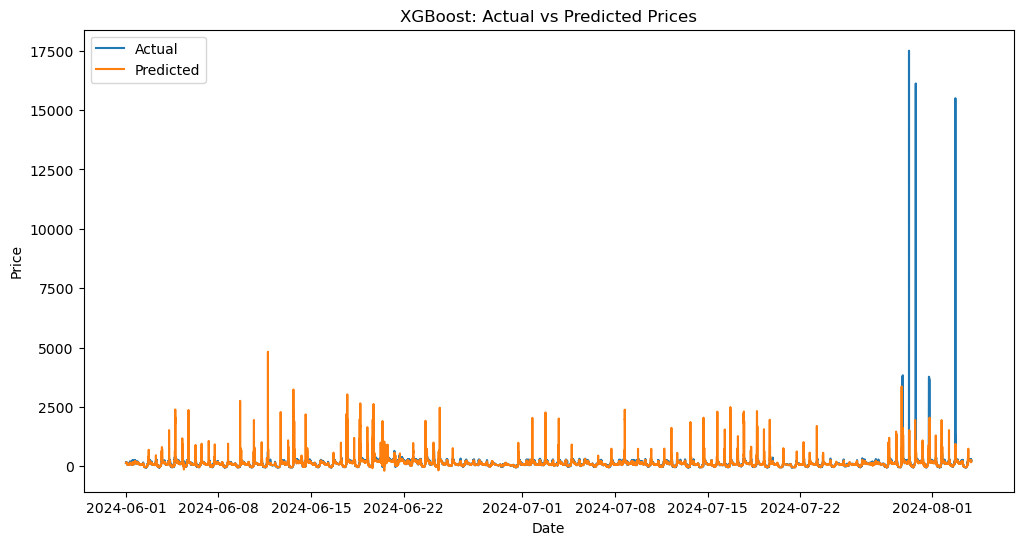

In [250]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.title('XGBoost: Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

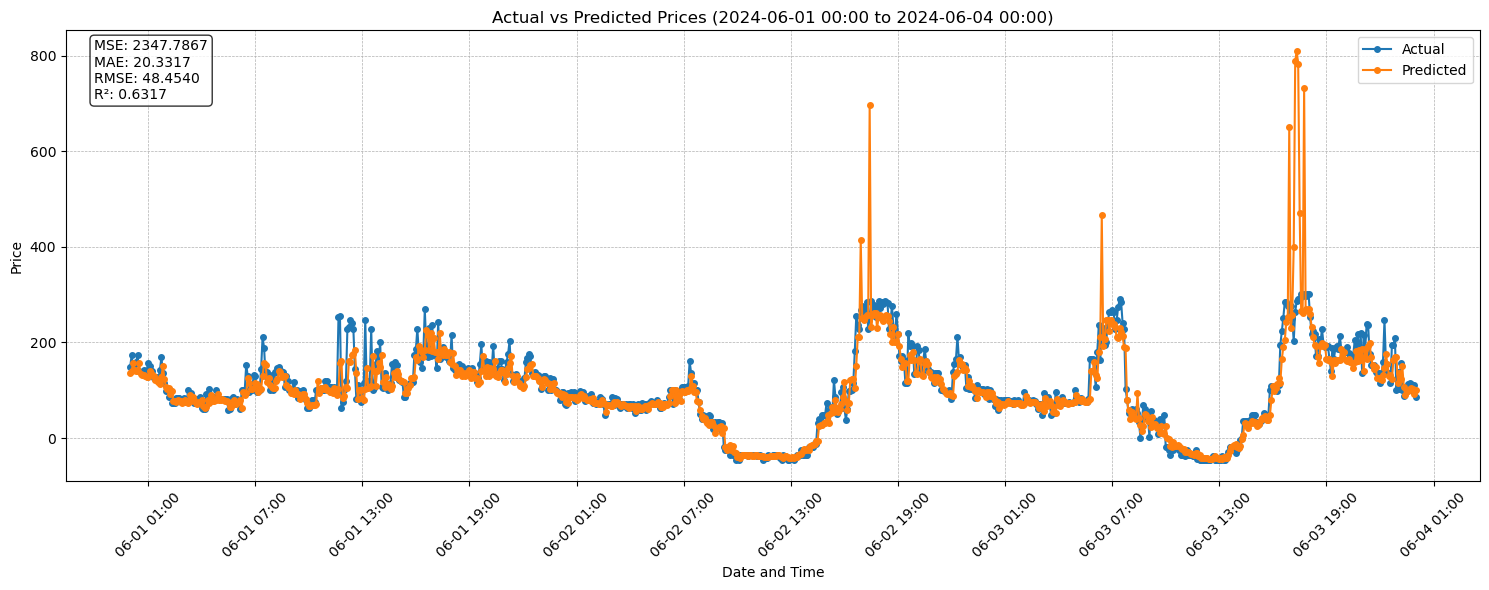

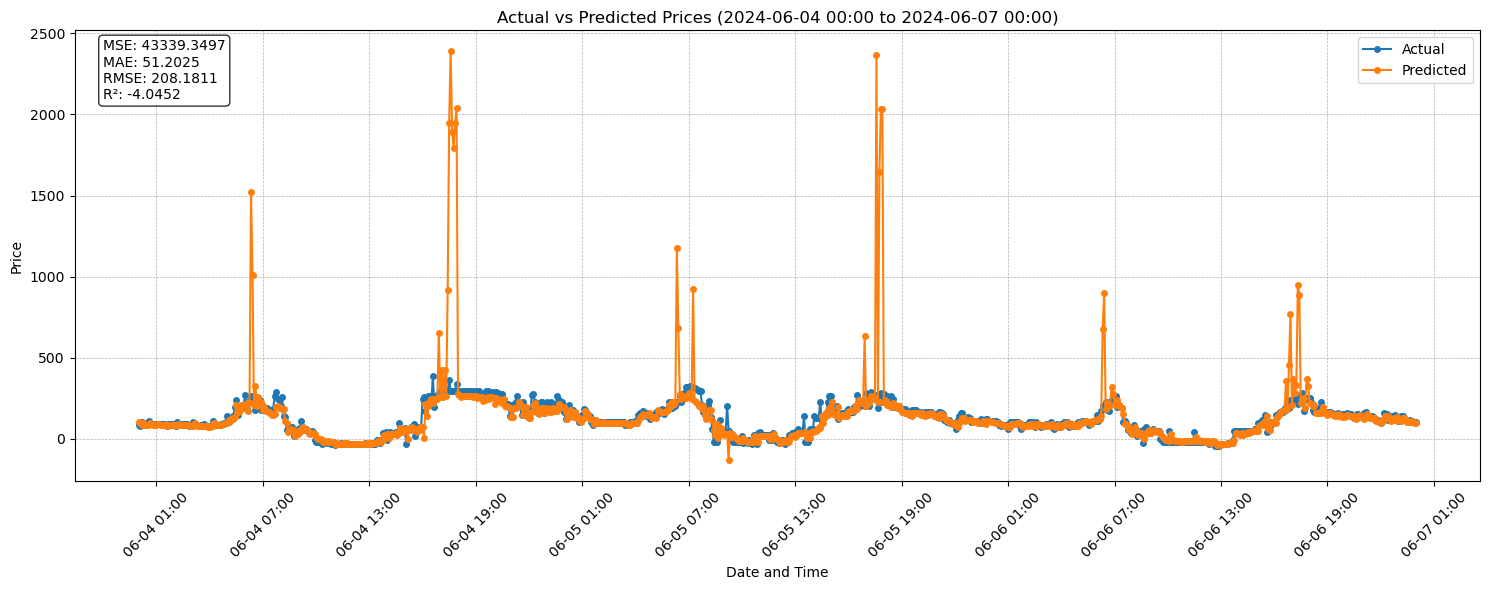

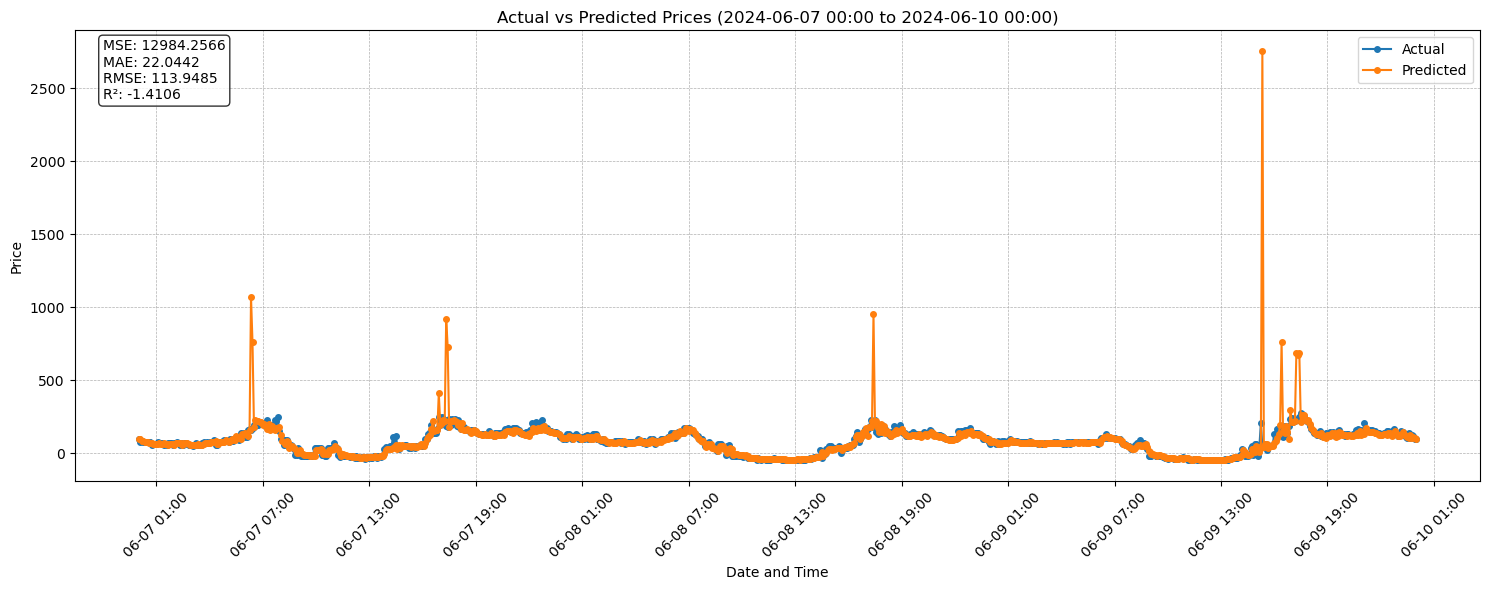

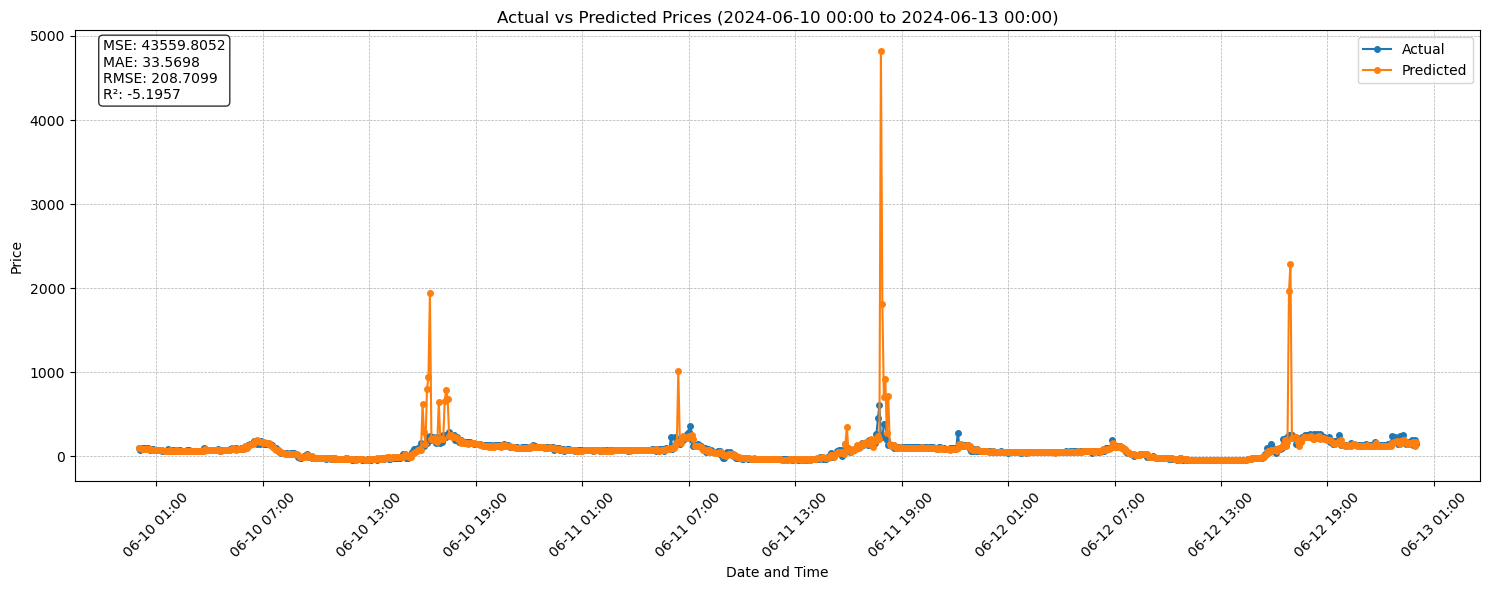

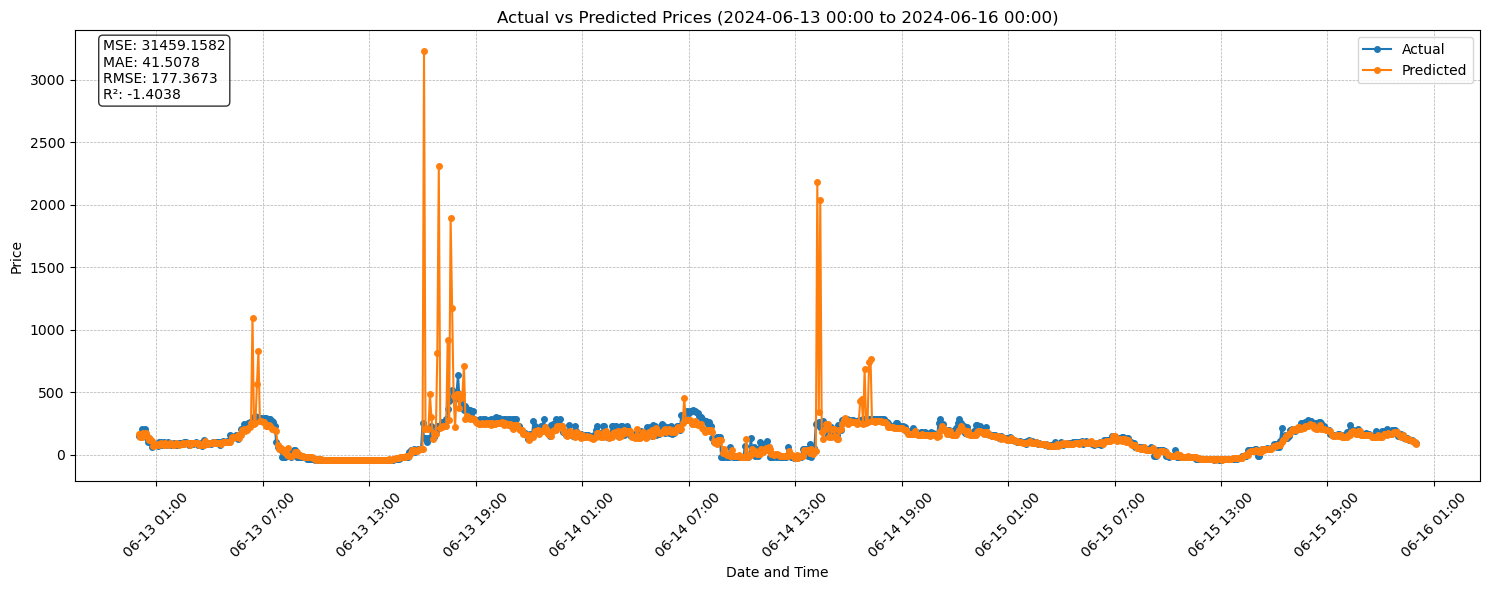

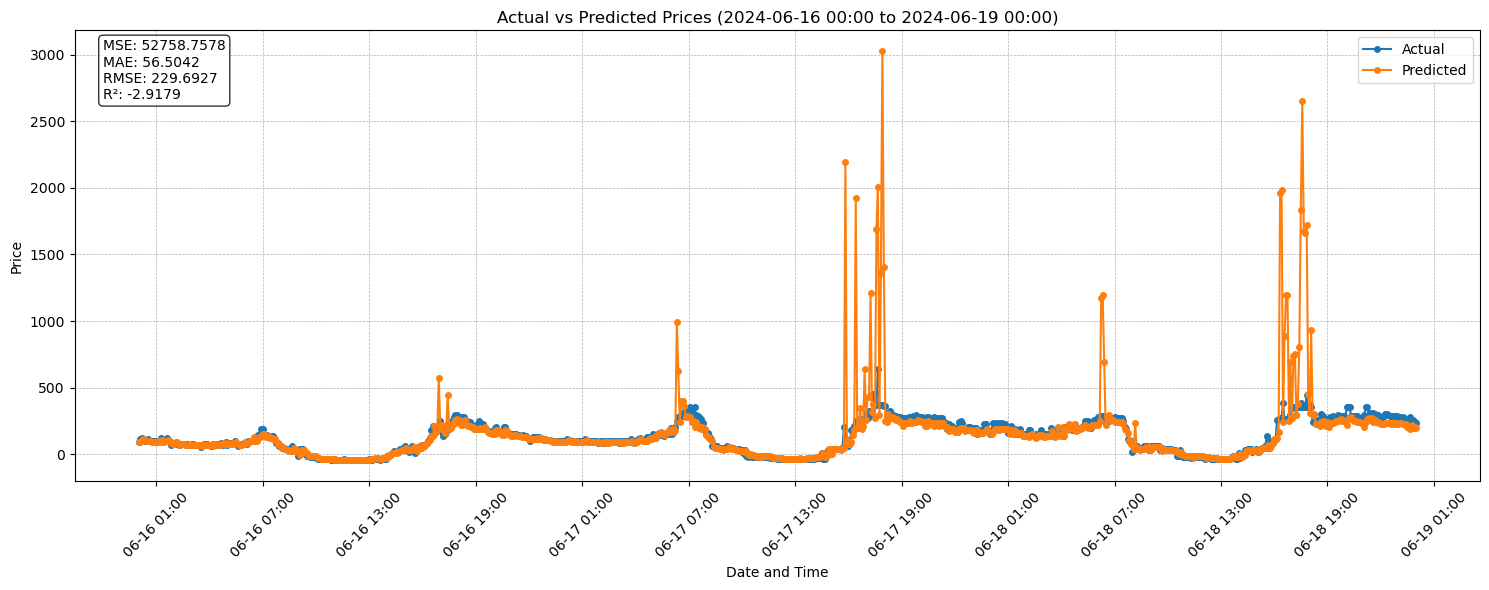

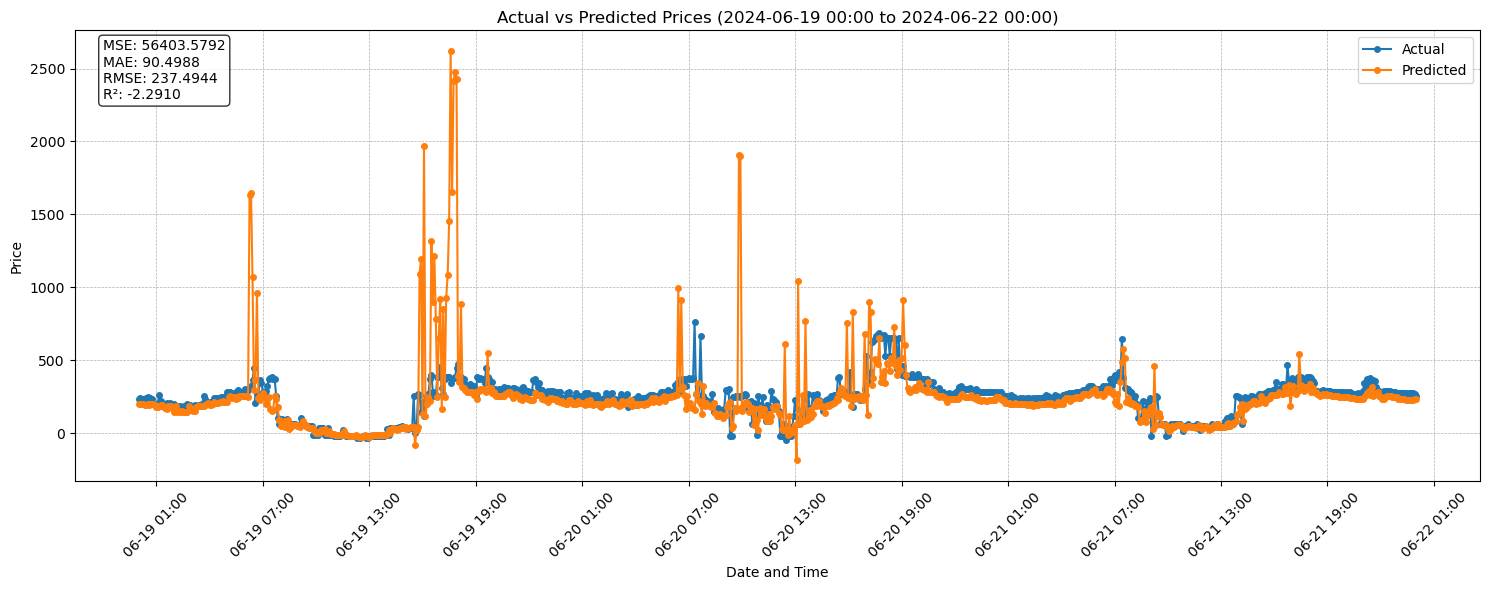

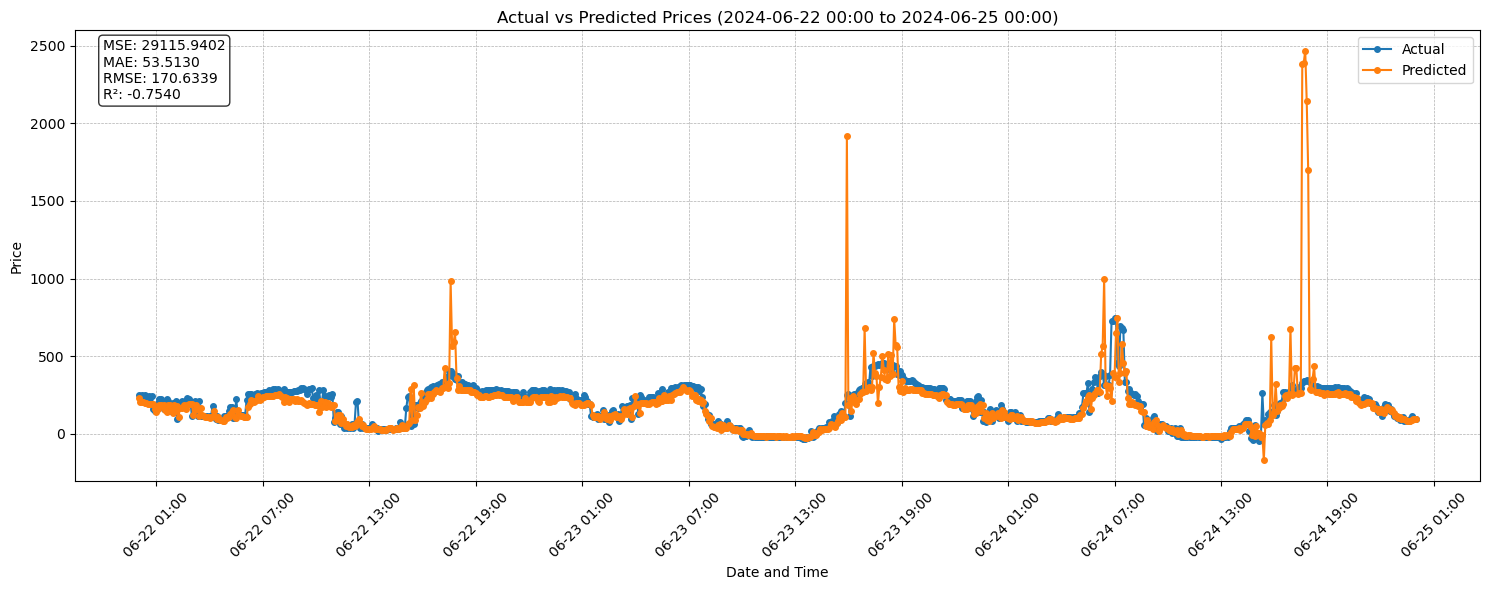

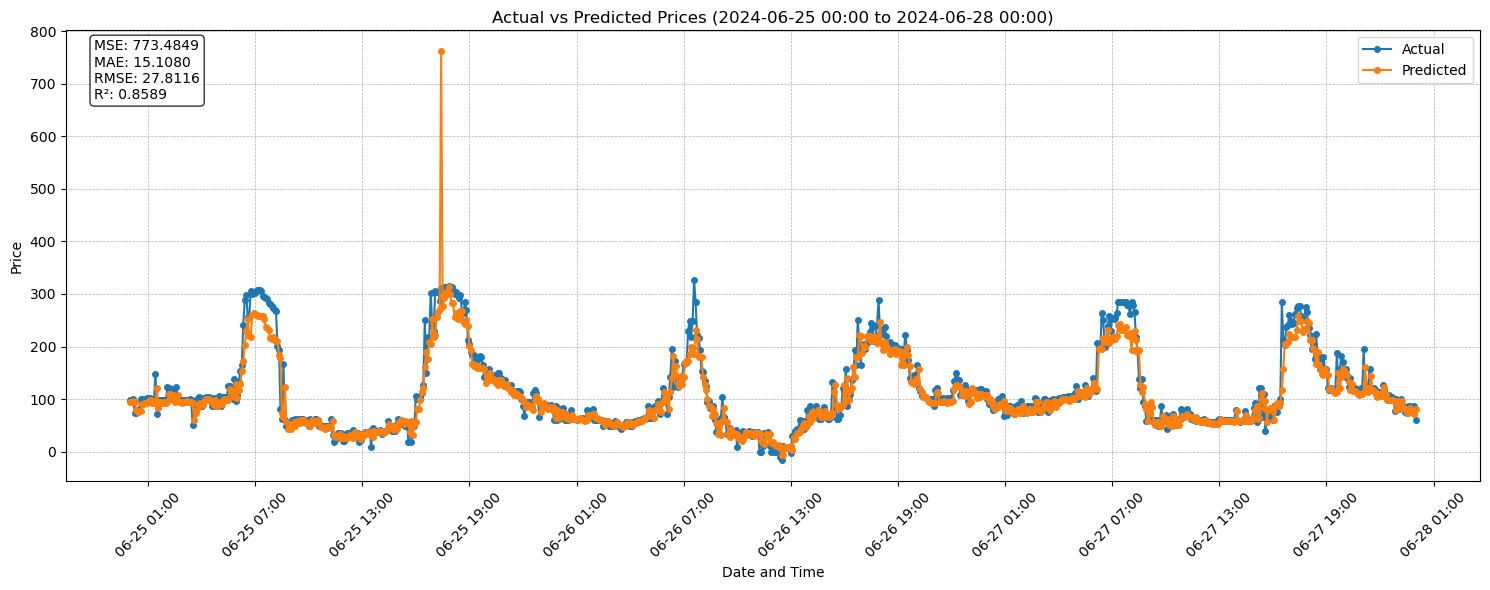

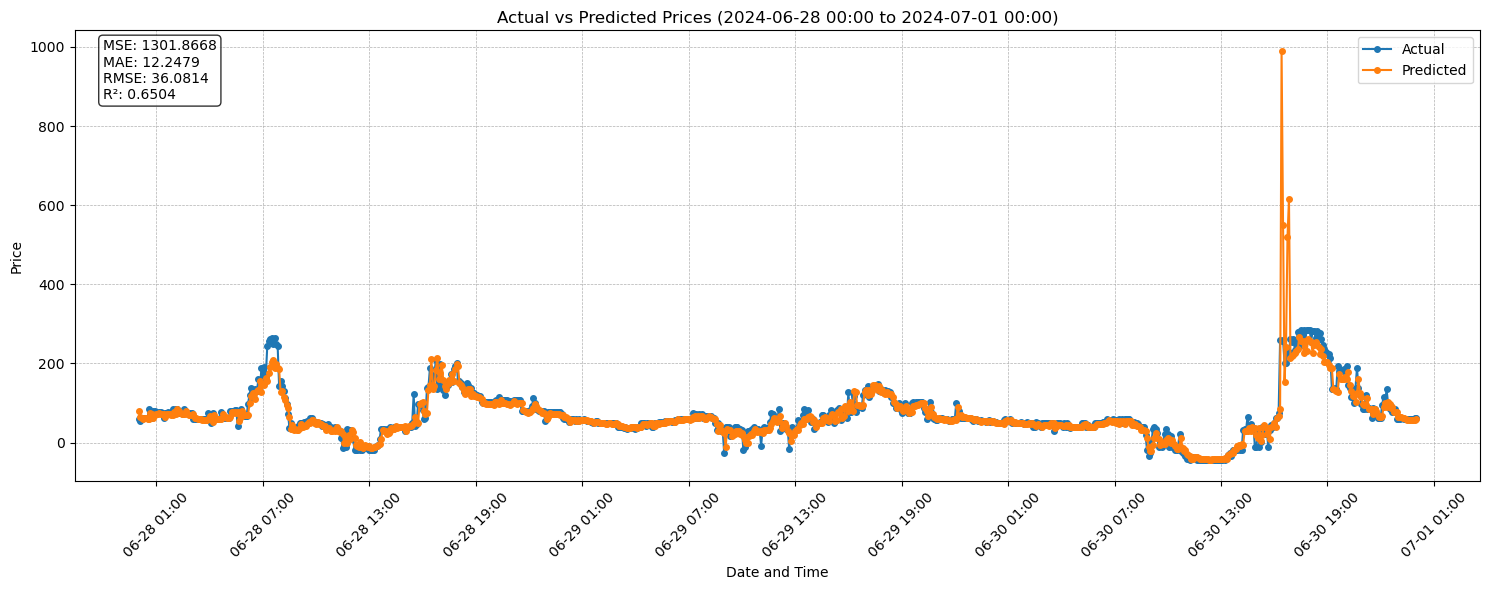

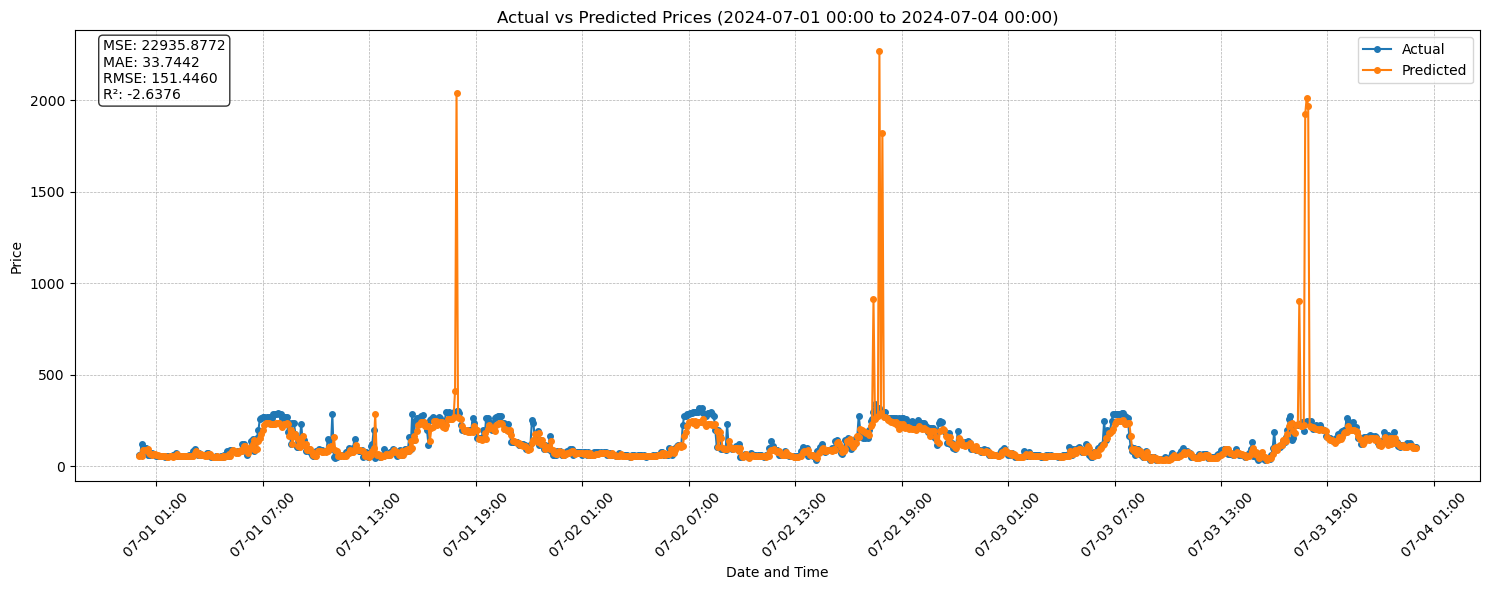

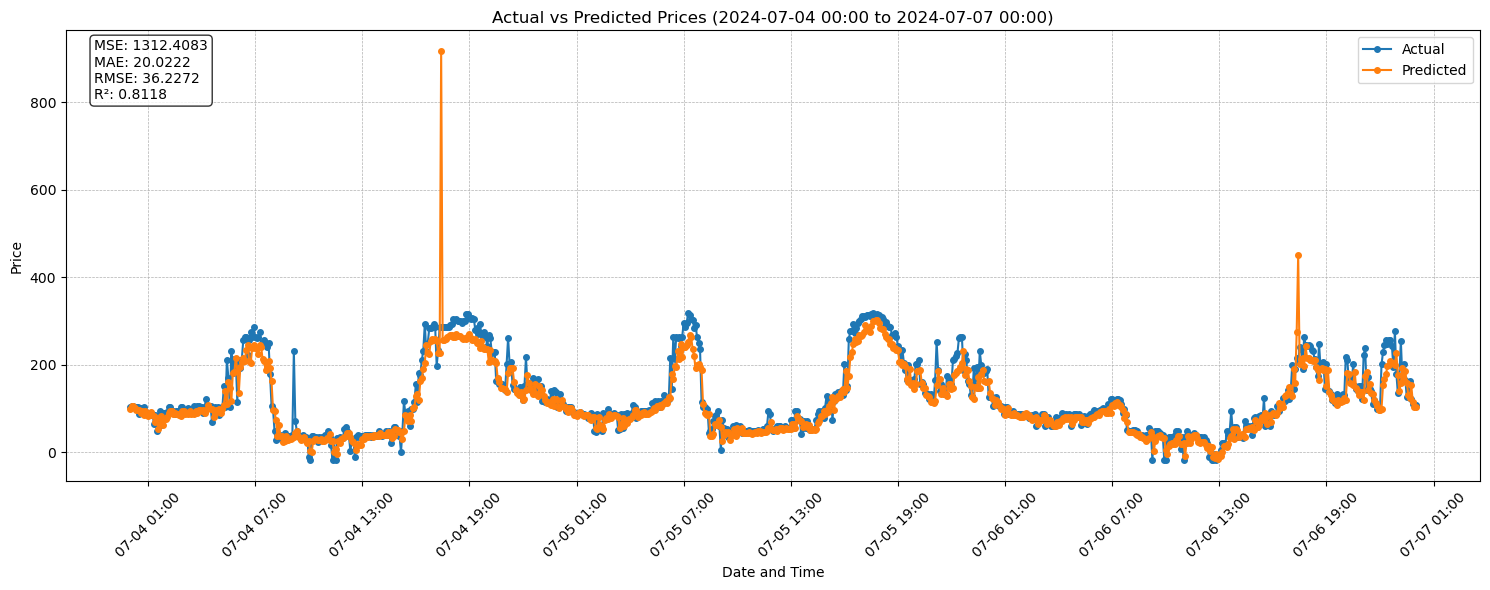

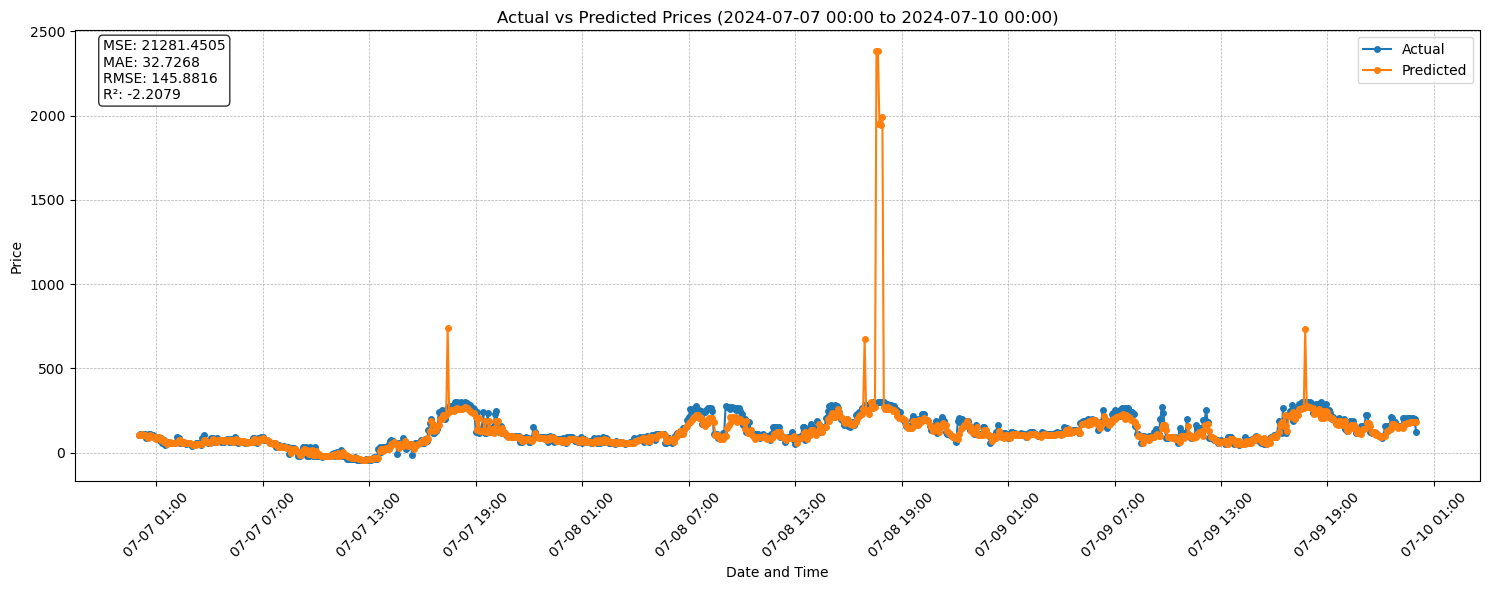

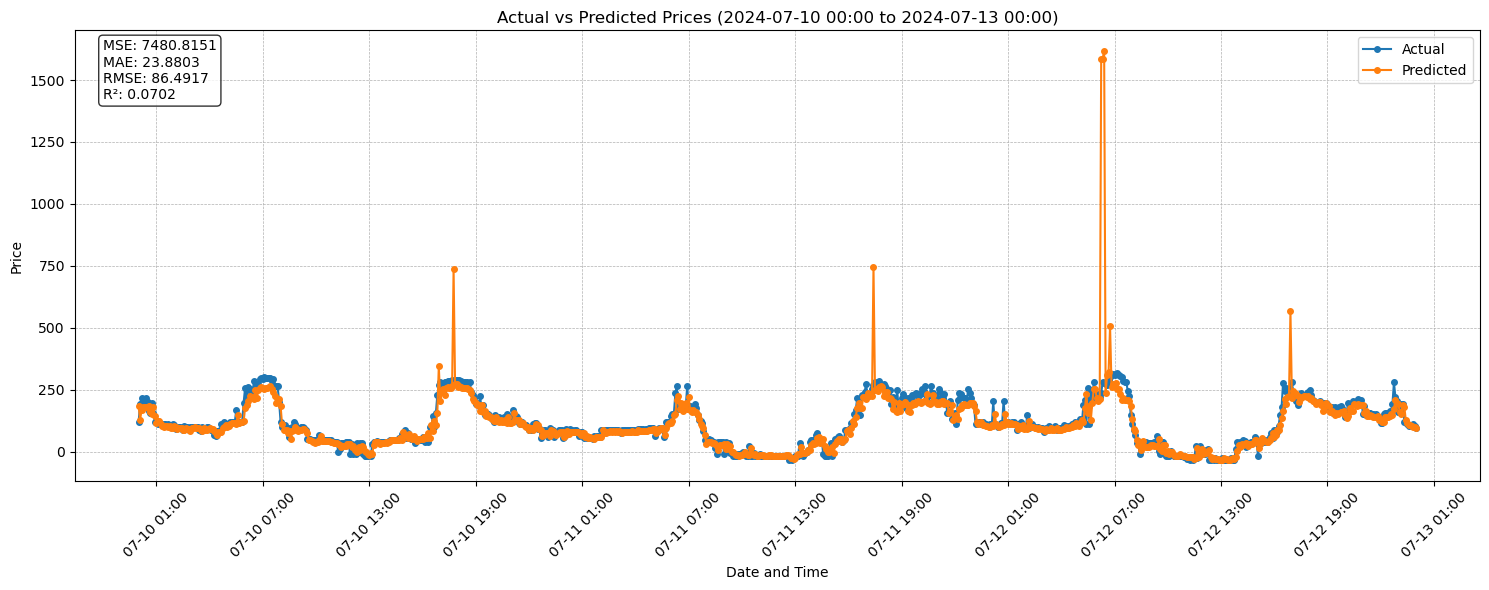

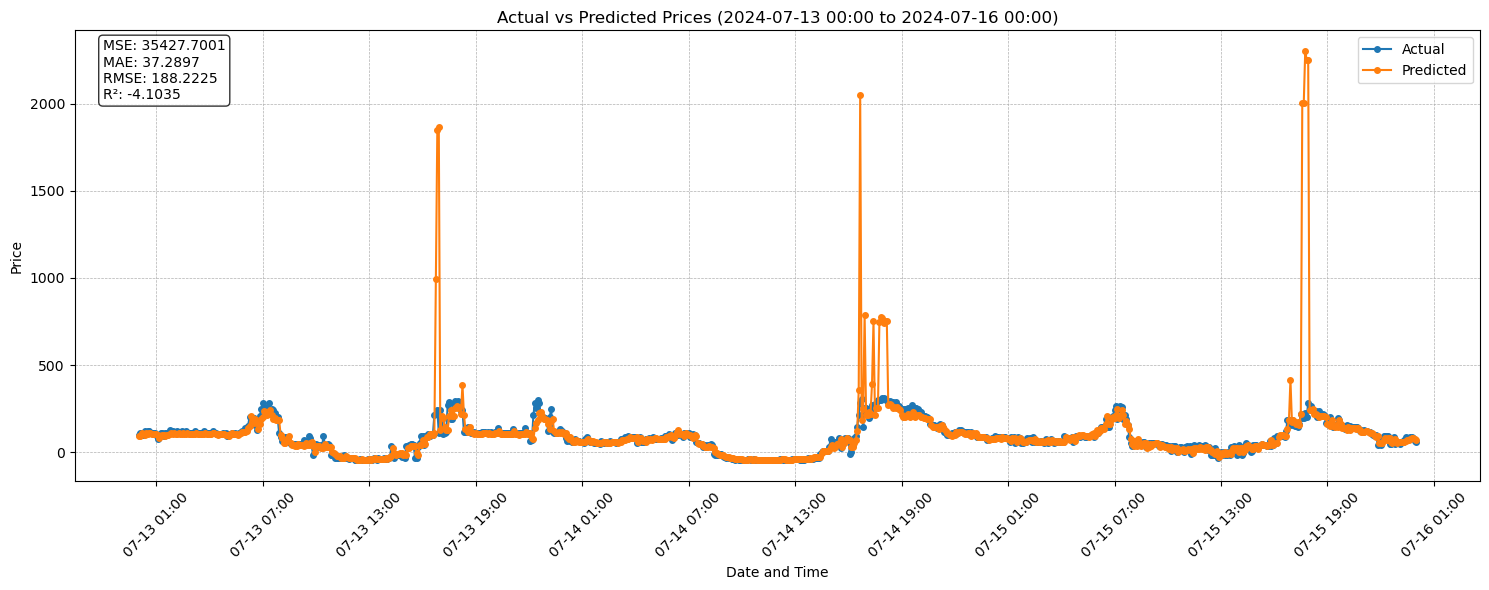

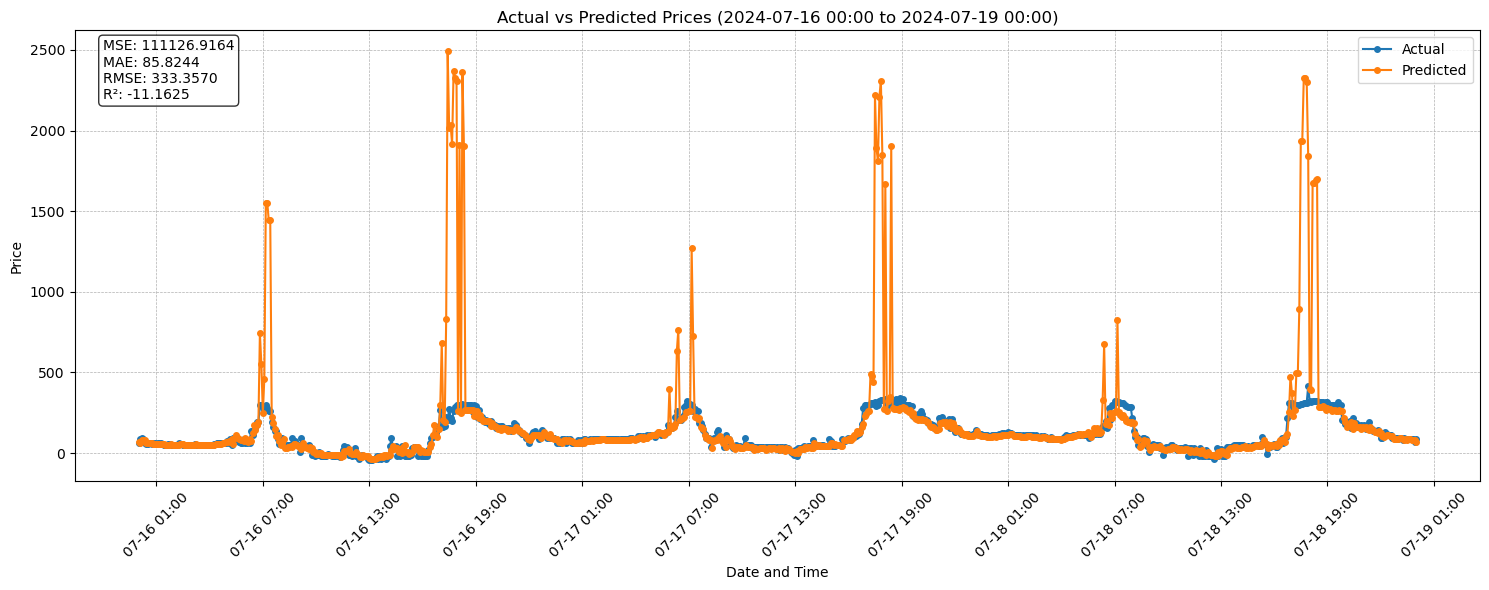

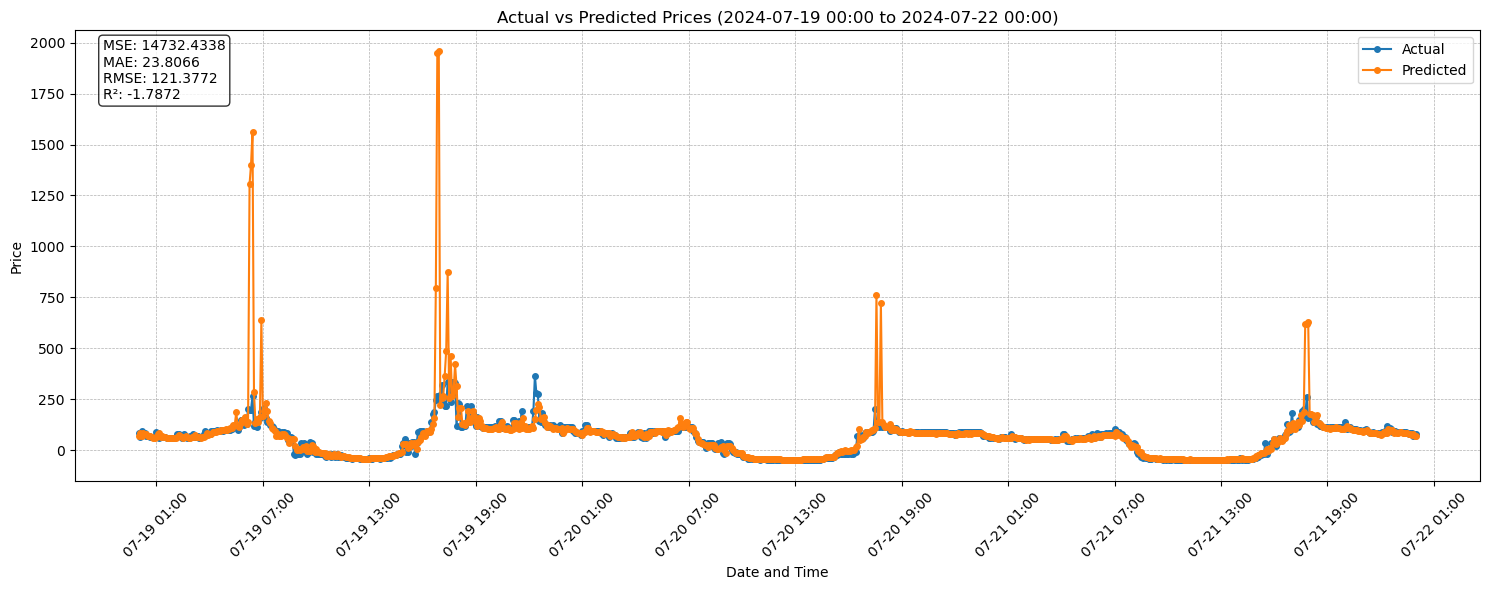

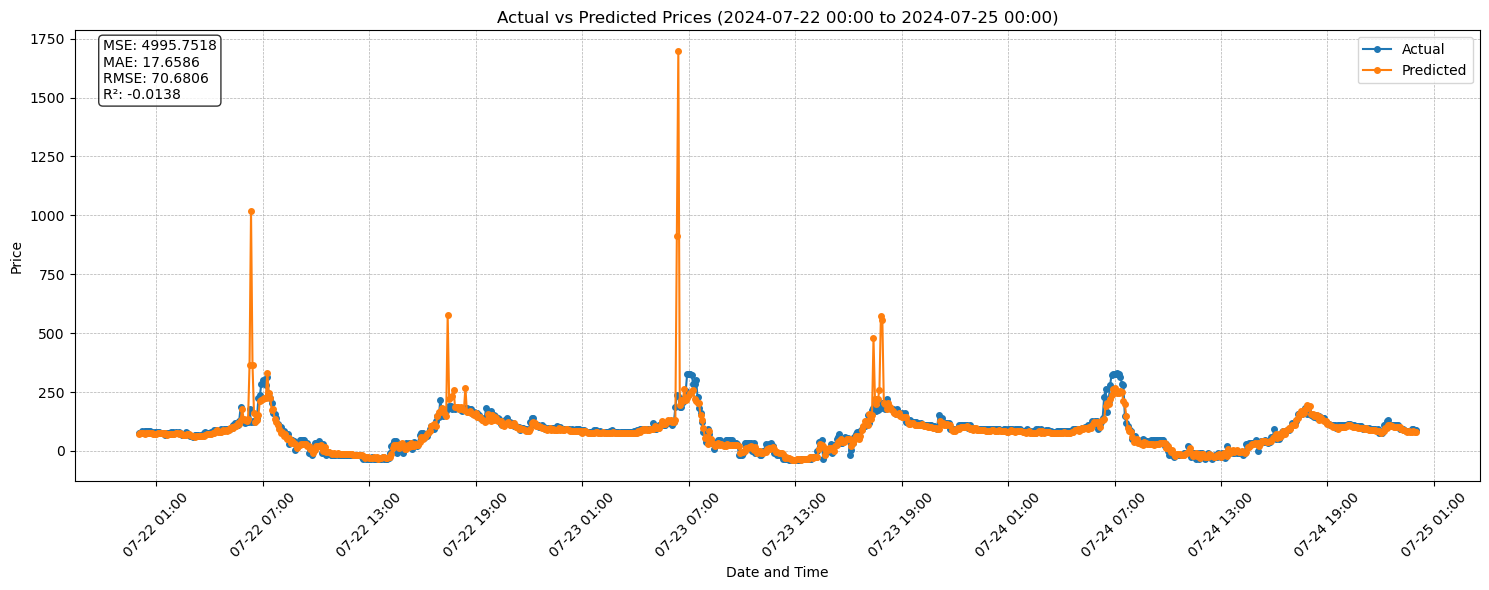

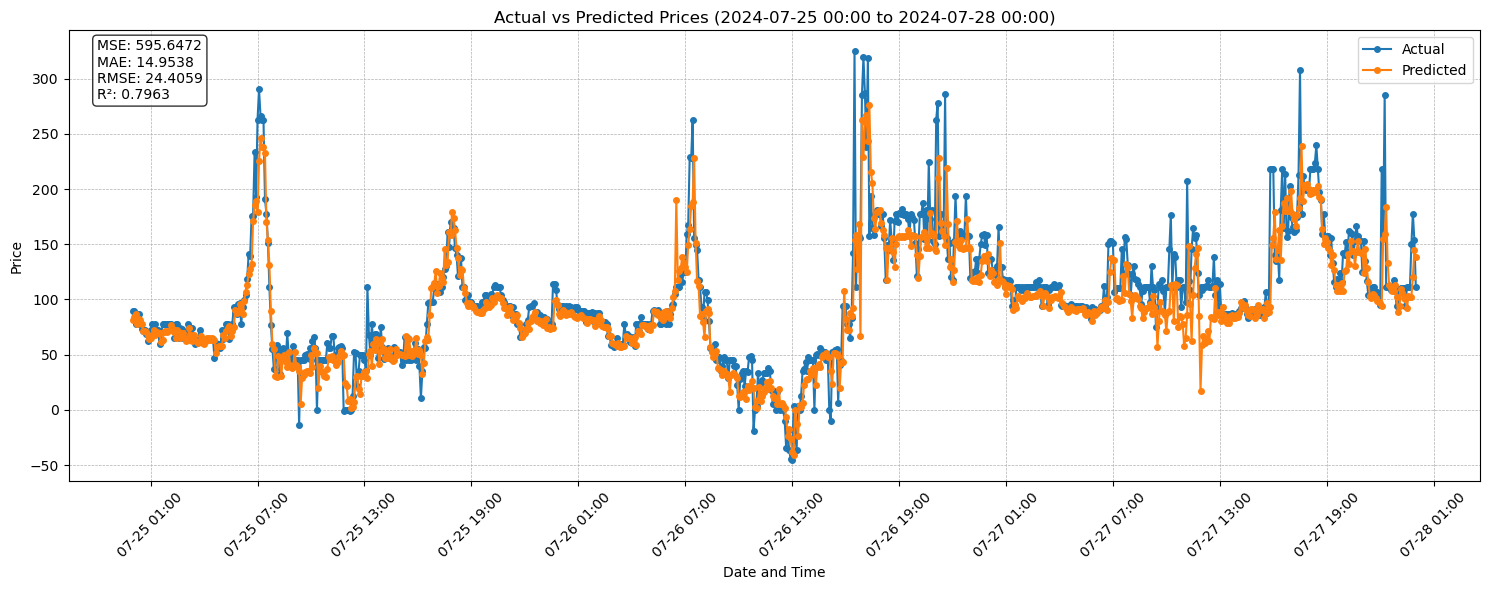

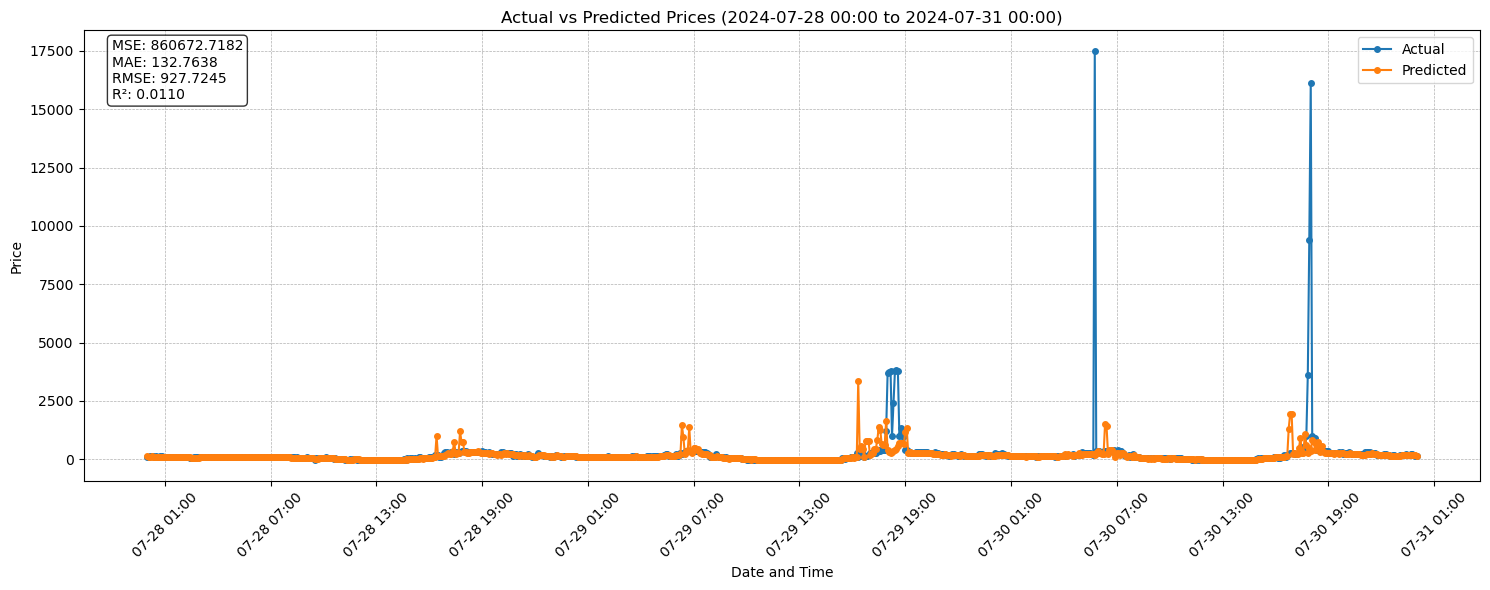

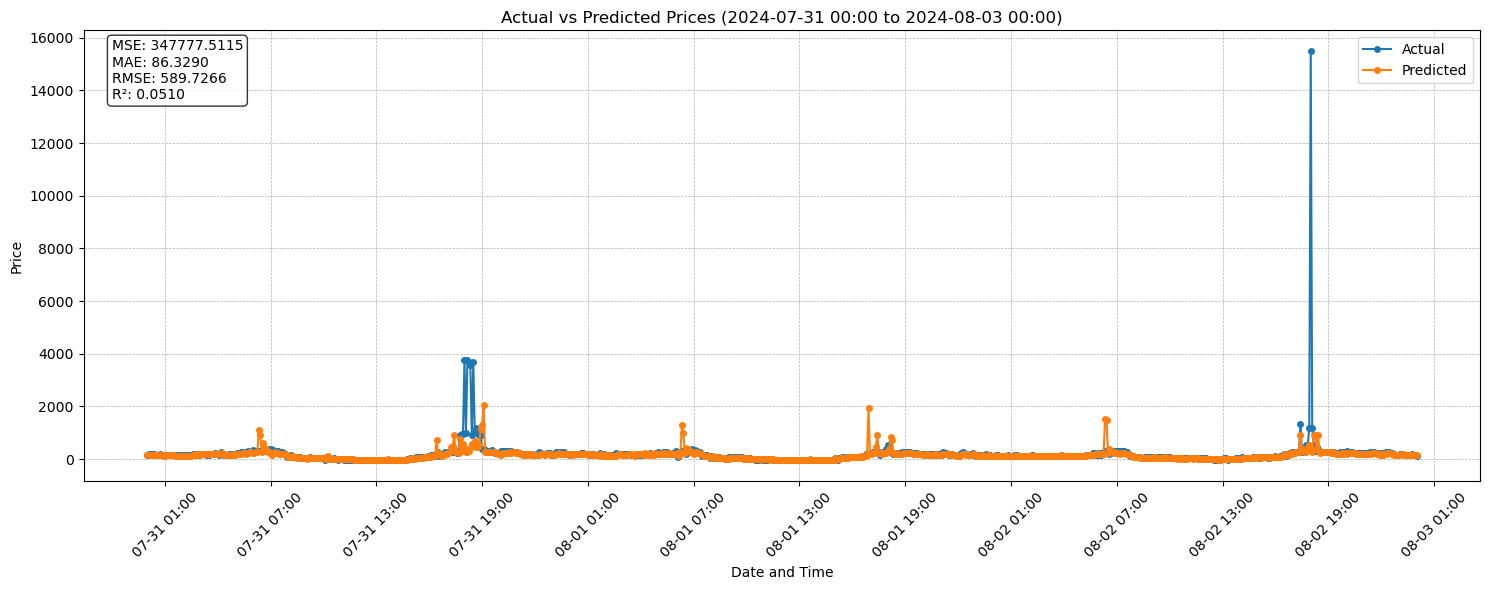

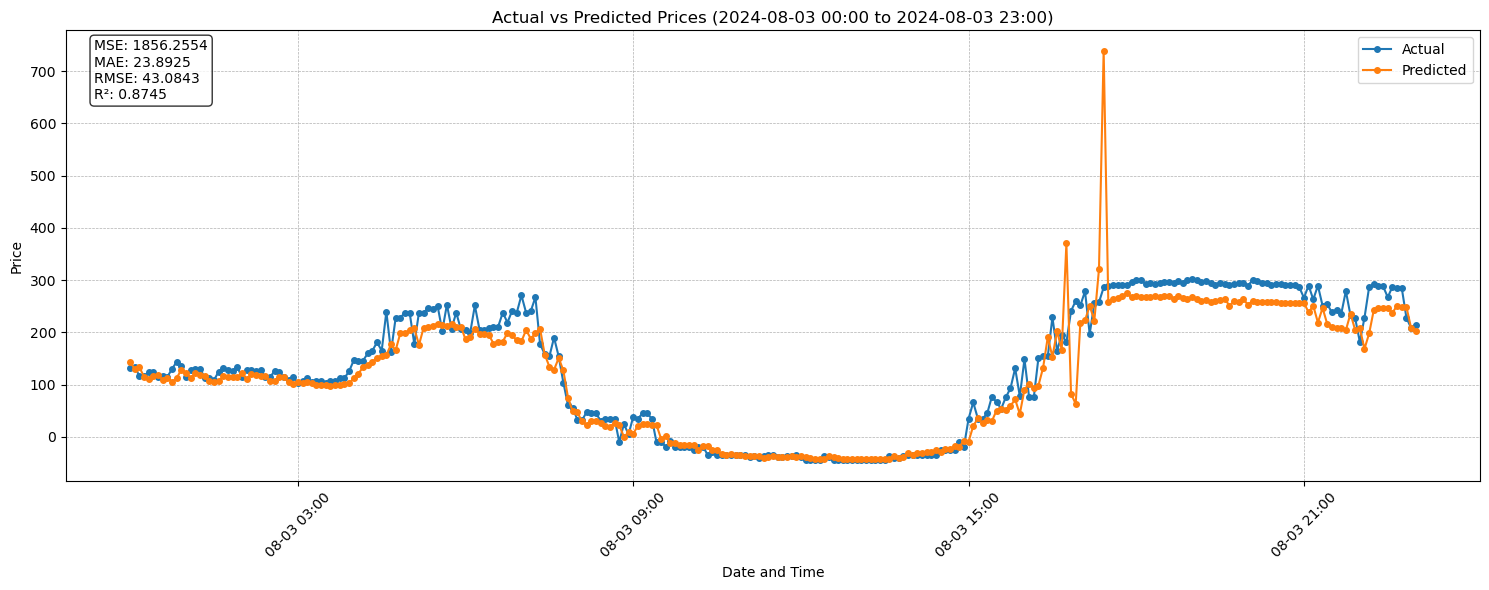

Overall Performance Metrics:
Mean Squared Error: 79966.7509
Mean Absolute Error: 42.8646
Root Mean Squared Error: 282.7839
R-squared Score: -0.1810


In [251]:

import matplotlib.pyplot as plt
from matplotlib.dates import DayLocator, HourLocator, DateFormatter

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)

def plot_three_day_comparison(data, start_date, end_date):
    period_data = data.loc[start_date:end_date]
    
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(period_data.index, period_data['Actual'], label='Actual', marker='o', markersize=4)
    ax.plot(period_data.index, period_data['Predicted'], label='Predicted', marker='o', markersize=4)
    
    ax.set_title(f'Actual vs Predicted Prices ({start_date.strftime("%Y-%m-%d %H:%M")} to {end_date.strftime("%Y-%m-%d %H:%M")})')
    ax.set_xlabel('Date and Time')
    ax.set_ylabel('Price')
    ax.legend()
    

    ax.xaxis.set_major_locator(HourLocator(interval=6)) 
    ax.xaxis.set_major_formatter(DateFormatter('%m-%d %H:%M'))
    # ax.xaxis.set_major_locator(DayLocator())  
    # ax.xaxis.set_minor_locator(HourLocator(interval=6))  
    # ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))  
    
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
 
    mse = mean_squared_error(period_data['Actual'], period_data['Predicted'])
    mae = mean_absolute_error(period_data['Actual'], period_data['Predicted'])
    rmse = np.sqrt(mse)
    r2 = r2_score(period_data['Actual'], period_data['Predicted'])
    
    metrics_text = f'MSE: {mse:.4f}\nMAE: {mae:.4f}\nRMSE: {rmse:.4f}\nR²: {r2:.4f}'
    plt.text(0.02, 0.98, metrics_text, transform=ax.transAxes, verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.show()


start_date = results_df.index.min()
end_date = results_df.index.max()


current_date = start_date
while current_date <= end_date:
    period_end = min(current_date + pd.Timedelta(days=3), end_date)
    plot_three_day_comparison(results_df, current_date, period_end)
    current_date += pd.Timedelta(days=3)

mse = mean_squared_error(results_df['Actual'], results_df['Predicted'])
mae = mean_absolute_error(results_df['Actual'], results_df['Predicted'])
rmse = np.sqrt(mse)
r2 = r2_score(results_df['Actual'], results_df['Predicted'])

print(f"Overall Performance Metrics:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared Score: {r2:.4f}")

In [252]:
results_df

,Actual,Predicted
date,,
2024-06-01 00:00:00,149.59,135.446579
2024-06-01 00:05:00,173.01,140.849945
2024-06-01 00:10:00,148.26,157.329834
2024-06-01 00:15:00,155.77,142.394882
2024-06-01 00:20:00,159.50,140.137573
...,...,...
2024-08-03 22:40:00,284.95,251.180145
2024-08-03 22:45:00,284.97,248.894119
2024-08-03 22:50:00,228.01,248.894119


In [253]:
print(results_df[results_df.index == "2024-07-30 05:40:00"])
results_df[results_df.index == "2024-07-30 05:45:00"]


                     Actual   Predicted
date                                   
2024-07-30 05:40:00  187.45  208.934677


,Actual,Predicted
date,,
2024-07-30 05:45:00,17500.0,200.498184


In [254]:
# 找到特定索引的位置
idx = X_test.index.get_loc("2024-07-30 05:40:00")


X_test.iloc[max(0, idx-5): idx+6]




,Forecast_Demand_0.5 hour future,Forecast_Demand_1 hour future,Forecast_Demand_1.5 hours future,Forecast_Demand_2 hours future,Forecast_Demand_2.5 hours future,Forecast_Demand_3 hours future,Forecast_Demand_3.5 hours future,Forecast_Demand_4 hours future,Forecast_Demand_4.5 hours future,Forecast_Demand_5 hours future,...,last_price_shift_3,last_price_shift_4,last_price_shift_5,last_price_shift_6,peak_hour_demand_lag_shift_1,peak_hour_demand_lag_shift_2,peak_hour_demand_lag_shift_3,peak_hour_demand_lag_shift_4,peak_hour_demand_lag_shift_5,peak_hour_demand_lag_shift_6
date,,,,,,,,,,,,,,,,,,,,,
2024-07-30 05:15:00,6543.0,6842.0,7247.0,7586.0,7681.0,7363.0,6798.0,6157.0,5557.0,5032.0,...,163.87,206.29,182.24,201.17,0.0,0.0,0.0,0.0,0.0,0.0
2024-07-30 05:20:00,6543.0,6842.0,7247.0,7586.0,7681.0,7363.0,6798.0,6157.0,5557.0,5032.0,...,299.06,163.87,206.29,182.24,0.0,0.0,0.0,0.0,0.0,0.0
2024-07-30 05:25:00,6543.0,6842.0,7247.0,7586.0,7681.0,7363.0,6798.0,6157.0,5557.0,5032.0,...,228.75,299.06,163.87,206.29,0.0,0.0,0.0,0.0,0.0,0.0
2024-07-30 05:30:00,6877.0,7383.0,7768.0,7841.0,7495.0,6895.0,6216.0,5596.0,5062.0,4677.0,...,284.95,228.75,299.06,163.87,0.0,0.0,0.0,0.0,0.0,0.0
2024-07-30 05:35:00,6877.0,7383.0,7768.0,7841.0,7495.0,6895.0,6216.0,5596.0,5062.0,4677.0,...,284.95,284.95,228.75,299.06,0.0,0.0,0.0,0.0,0.0,0.0
2024-07-30 05:40:00,6877.0,7383.0,7768.0,7841.0,7495.0,6895.0,6216.0,5596.0,5062.0,4677.0,...,256.31,284.95,284.95,228.75,0.0,0.0,0.0,0.0,0.0,0.0
2024-07-30 05:45:00,6877.0,7383.0,7768.0,7841.0,7495.0,6895.0,6216.0,5596.0,5062.0,4677.0,...,261.69,256.31,284.95,284.95,0.0,0.0,0.0,0.0,0.0,0.0
2024-07-30 05:50:00,6877.0,7383.0,7768.0,7841.0,7495.0,6895.0,6216.0,5596.0,5062.0,4677.0,...,285.57,261.69,256.31,284.95,0.0,0.0,0.0,0.0,0.0,0.0
2024-07-30 05:55:00,6877.0,7383.0,7768.0,7841.0,7495.0,6895.0,6216.0,5596.0,5062.0,4677.0,...,207.51,285.57,261.69,256.31,0.0,0.0,0.0,0.0,0.0,0.0


Hourly Success Rate (sorted from highest to lowest):
hour
3     0.679688
2     0.661458
1     0.653646
4     0.644531
21    0.609375
0     0.589844
5     0.569010
23    0.565390
20    0.558594
19    0.531250
18    0.498698
22    0.446615
12    0.412760
13    0.386719
6     0.381510
17    0.343750
11    0.304688
7     0.290365
16    0.290365
15    0.276042
14    0.268229
10    0.244792
8     0.207031
9     0.180990
Name: is_successful, dtype: float64


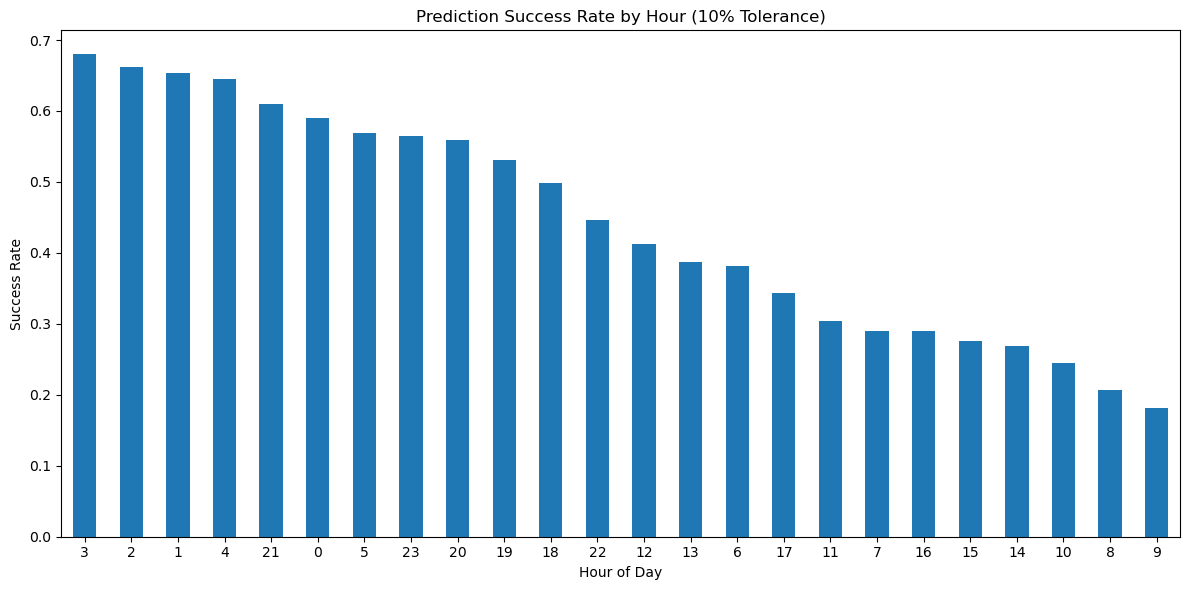

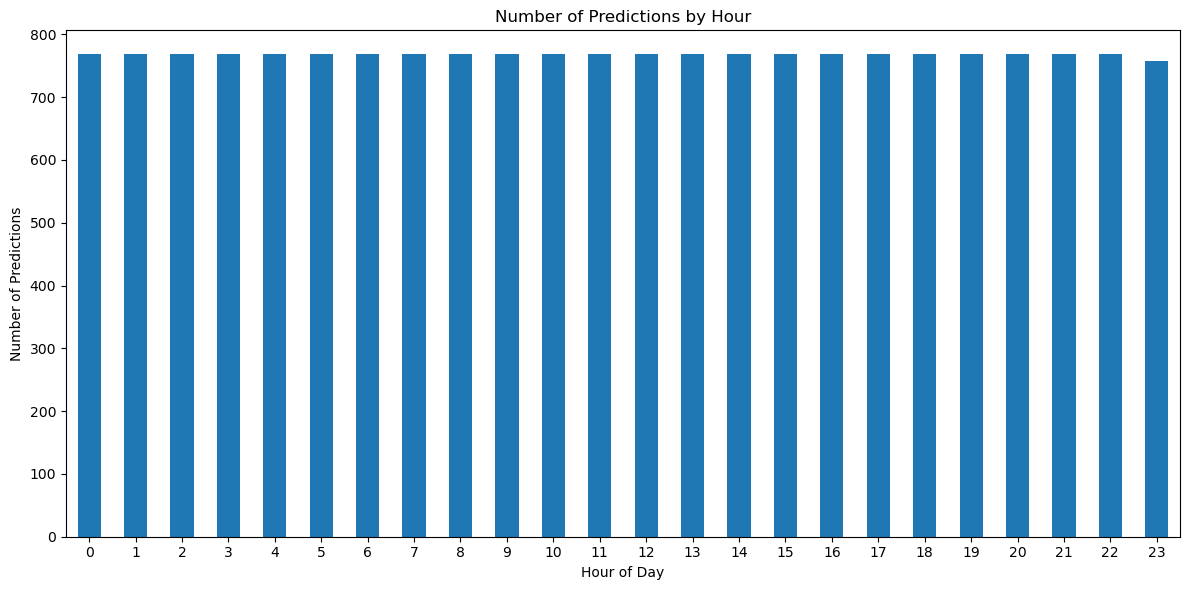


Top 5 hours with highest success rate:
hour
3     0.679688
2     0.661458
1     0.653646
4     0.644531
21    0.609375
Name: is_successful, dtype: float64

Bottom 5 hours with lowest success rate:
hour
9     0.180990
8     0.207031
10    0.244792
14    0.268229
15    0.276042
Name: is_successful, dtype: float64

Overall Success Rate: 44.14%


In [255]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def is_prediction_successful(actual, predicted, tolerance=0.1):
    return abs(predicted - actual) <= abs(actual * tolerance)


results_df['is_successful'] = results_df.apply(lambda row: is_prediction_successful(row['Actual'], row['Predicted']), axis=1)


results_df['hour'] = results_df.index.hour
hourly_success_rate = results_df.groupby('hour')['is_successful'].mean().sort_values(ascending=False)


hourly_prediction_count = results_df.groupby('hour').size()


print("Hourly Success Rate (sorted from highest to lowest):")
print(hourly_success_rate)


plt.figure(figsize=(12, 6))
hourly_success_rate.plot(kind='bar')
plt.title('Prediction Success Rate by Hour (10% Tolerance)')
plt.xlabel('Hour of Day')
plt.ylabel('Success Rate')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
hourly_prediction_count.plot(kind='bar')
plt.title('Number of Predictions by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Predictions')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

top_5_hours = hourly_success_rate.nlargest(5)
bottom_5_hours = hourly_success_rate.nsmallest(5)

print("\nTop 5 hours with highest success rate:")
print(top_5_hours)

print("\nBottom 5 hours with lowest success rate:")
print(bottom_5_hours)

# 計算總體成功率
overall_success_rate = results_df['is_successful'].mean()
print(f"\nOverall Success Rate: {overall_success_rate:.2%}")


# fig, ax1 = plt.subplots(figsize=(15, 6))

# ax1.bar(hourly_success_rate.index, hourly_success_rate.values, alpha=0.7, color='b', label='Success Rate')
# ax1.set_xlabel('Hour of Day')
# ax1.set_ylabel('Success Rate', color='b')
# ax1.tick_params(axis='y', labelcolor='b')

# ax2 = ax1.twinx()
# ax2.plot(hourly_prediction_count.index, hourly_prediction_count.values, color='r', label='Prediction Count')
# ax2.set_ylabel('Number of Predictions', color='r')
# ax2.tick_params(axis='y', labelcolor='r')

# plt.title('Prediction Success Rate and Count by Hour')
# fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
# plt.tight_layout()
# plt.show()

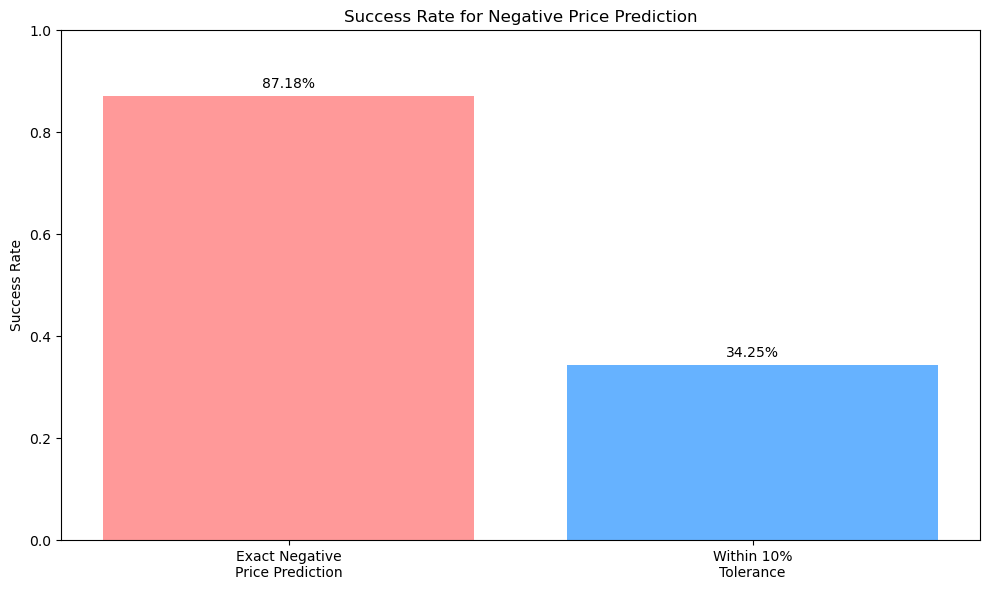

Exact Negative Price Prediction Success Rate: 87.18%
Negative Price Prediction Success Rate (10% Tolerance): 34.25%
Frequency of Negative Prices: 12.79%


In [256]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def is_prediction_successful(actual, predicted, tolerance=0.1):
    return abs(predicted - actual) <= abs(actual * tolerance)


results_df['is_successful'] = results_df.apply(lambda row: is_prediction_successful(row['Actual'], row['Predicted']), axis=1)


def analyze_negative_price_prediction(df):
    negative_price_df = df[df['Actual'] < 0]
    

    exact_success = ((negative_price_df['Predicted'] < 0) & (negative_price_df['Actual'] < 0)).mean()

    tolerance_success = negative_price_df['is_successful'].mean()
    
    return exact_success, tolerance_success


exact_success_rate, tolerance_success_rate = analyze_negative_price_prediction(results_df)


plt.figure(figsize=(10, 6))
success_rates = [exact_success_rate, tolerance_success_rate]
labels = ['Exact Negative\nPrice Prediction', 'Within 10%\nTolerance']
colors = ['#FF9999', '#66B2FF']

plt.bar(labels, success_rates, color=colors)
plt.title('Success Rate for Negative Price Prediction')
plt.ylabel('Success Rate')
plt.ylim(0, 1)  


for i, v in enumerate(success_rates):
    plt.text(i, v + 0.01, f'{v:.2%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


print(f"Exact Negative Price Prediction Success Rate: {exact_success_rate:.2%}")
print(f"Negative Price Prediction Success Rate (10% Tolerance): {tolerance_success_rate:.2%}")


negative_price_frequency = (results_df['Actual'] < 0).mean()
print(f"Frequency of Negative Prices: {negative_price_frequency:.2%}")

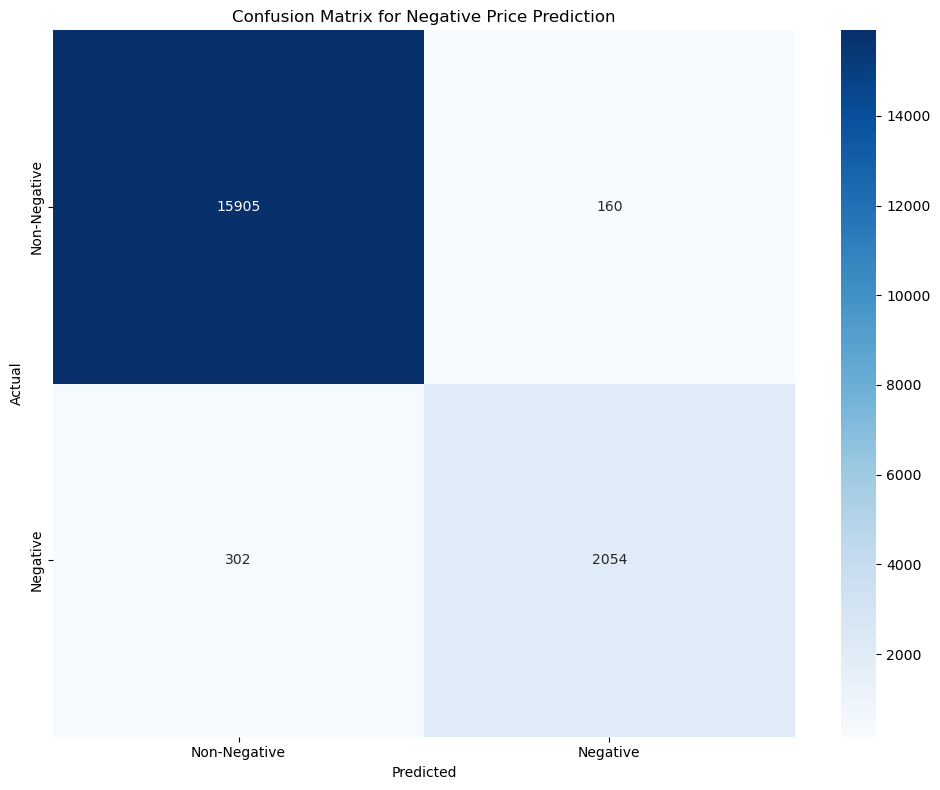

Classification Report for Negative Price Prediction:
              precision    recall  f1-score   support

Non-Negative       0.98      0.99      0.99     16065
    Negative       0.93      0.87      0.90      2356

    accuracy                           0.97     18421
   macro avg       0.95      0.93      0.94     18421
weighted avg       0.97      0.97      0.97     18421


Accuracy: 0.9749
Precision: 0.9277
Recall: 0.8718
F1 Score: 0.8989
Frequency of Negative Prices: 12.79%


In [257]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def analyze_negative_price_prediction(df):
    # 將實際值和預測值轉換為二元類別（負價為1，非負價為0）
    actual_binary = (df['Actual'] < 0).astype(int)
    predicted_binary = (df['Predicted'] < 0).astype(int)
    
    # 計算混淆矩陣
    cm = confusion_matrix(actual_binary, predicted_binary)
    
    # 計算分類報告
    report = classification_report(actual_binary, predicted_binary, target_names=['Non-Negative', 'Negative'])
    
    return cm, report

# 假設 results_df 已經包含 'Actual' 和 'Predicted' 列
cm, report = analyze_negative_price_prediction(results_df)

# 繪製混淆矩陣
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Negative Price Prediction')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks([0.5, 1.5], ['Non-Negative', 'Negative'])
plt.yticks([0.5, 1.5], ['Non-Negative', 'Negative'])
plt.tight_layout()
plt.show()

# 打印分類報告
print("Classification Report for Negative Price Prediction:")
print(report)

# 計算並打印其他指標
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# 計算負價的頻率
negative_price_frequency = (results_df['Actual'] < 0).mean()
print(f"Frequency of Negative Prices: {negative_price_frequency:.2%}")


False Positives (Predicted Negative, Actually Non-Negative) by hour of day:
date
8      5
9     23
10    23
11    23
12    11
13    27
14    30
15    18
dtype: int64

False Positives (Predicted Negative, Actually Non-Negative) by day of week:
date
Friday       22
Monday       21
Saturday     18
Sunday       30
Thursday     22
Tuesday      20
Wednesday    27
dtype: int64

False Positives (Predicted Negative, Actually Non-Negative) by month:
date
August     7
July      79
June      74
dtype: int64


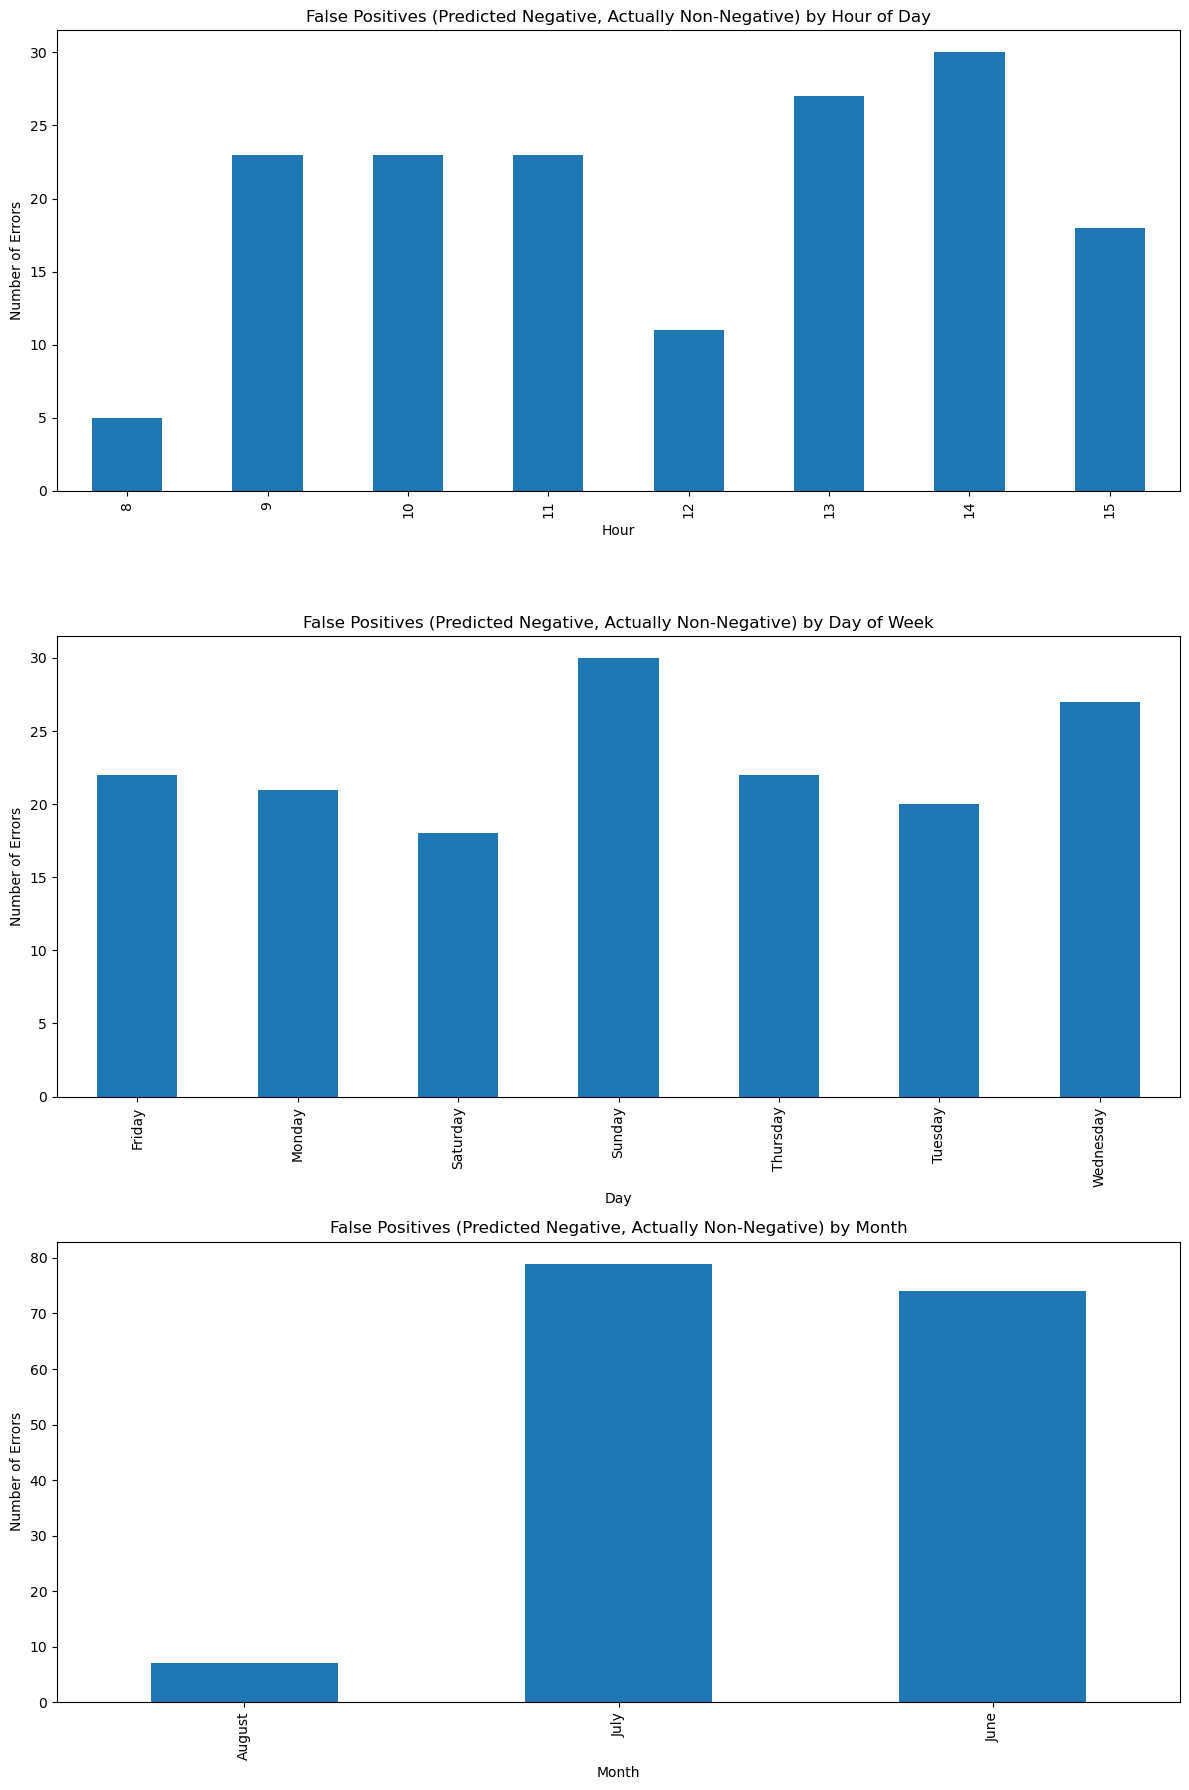


False Negatives (Predicted Non-Negative, Actually Negative) by hour of day:
date
8     27
9     65
10    58
11    36
12    33
13    16
14    25
15    31
16    11
dtype: int64

False Negatives (Predicted Non-Negative, Actually Negative) by day of week:
date
Friday       55
Monday       36
Saturday     34
Sunday       40
Thursday     50
Tuesday      42
Wednesday    45
dtype: int64

False Negatives (Predicted Non-Negative, Actually Negative) by month:
date
August     11
July      149
June      142
dtype: int64


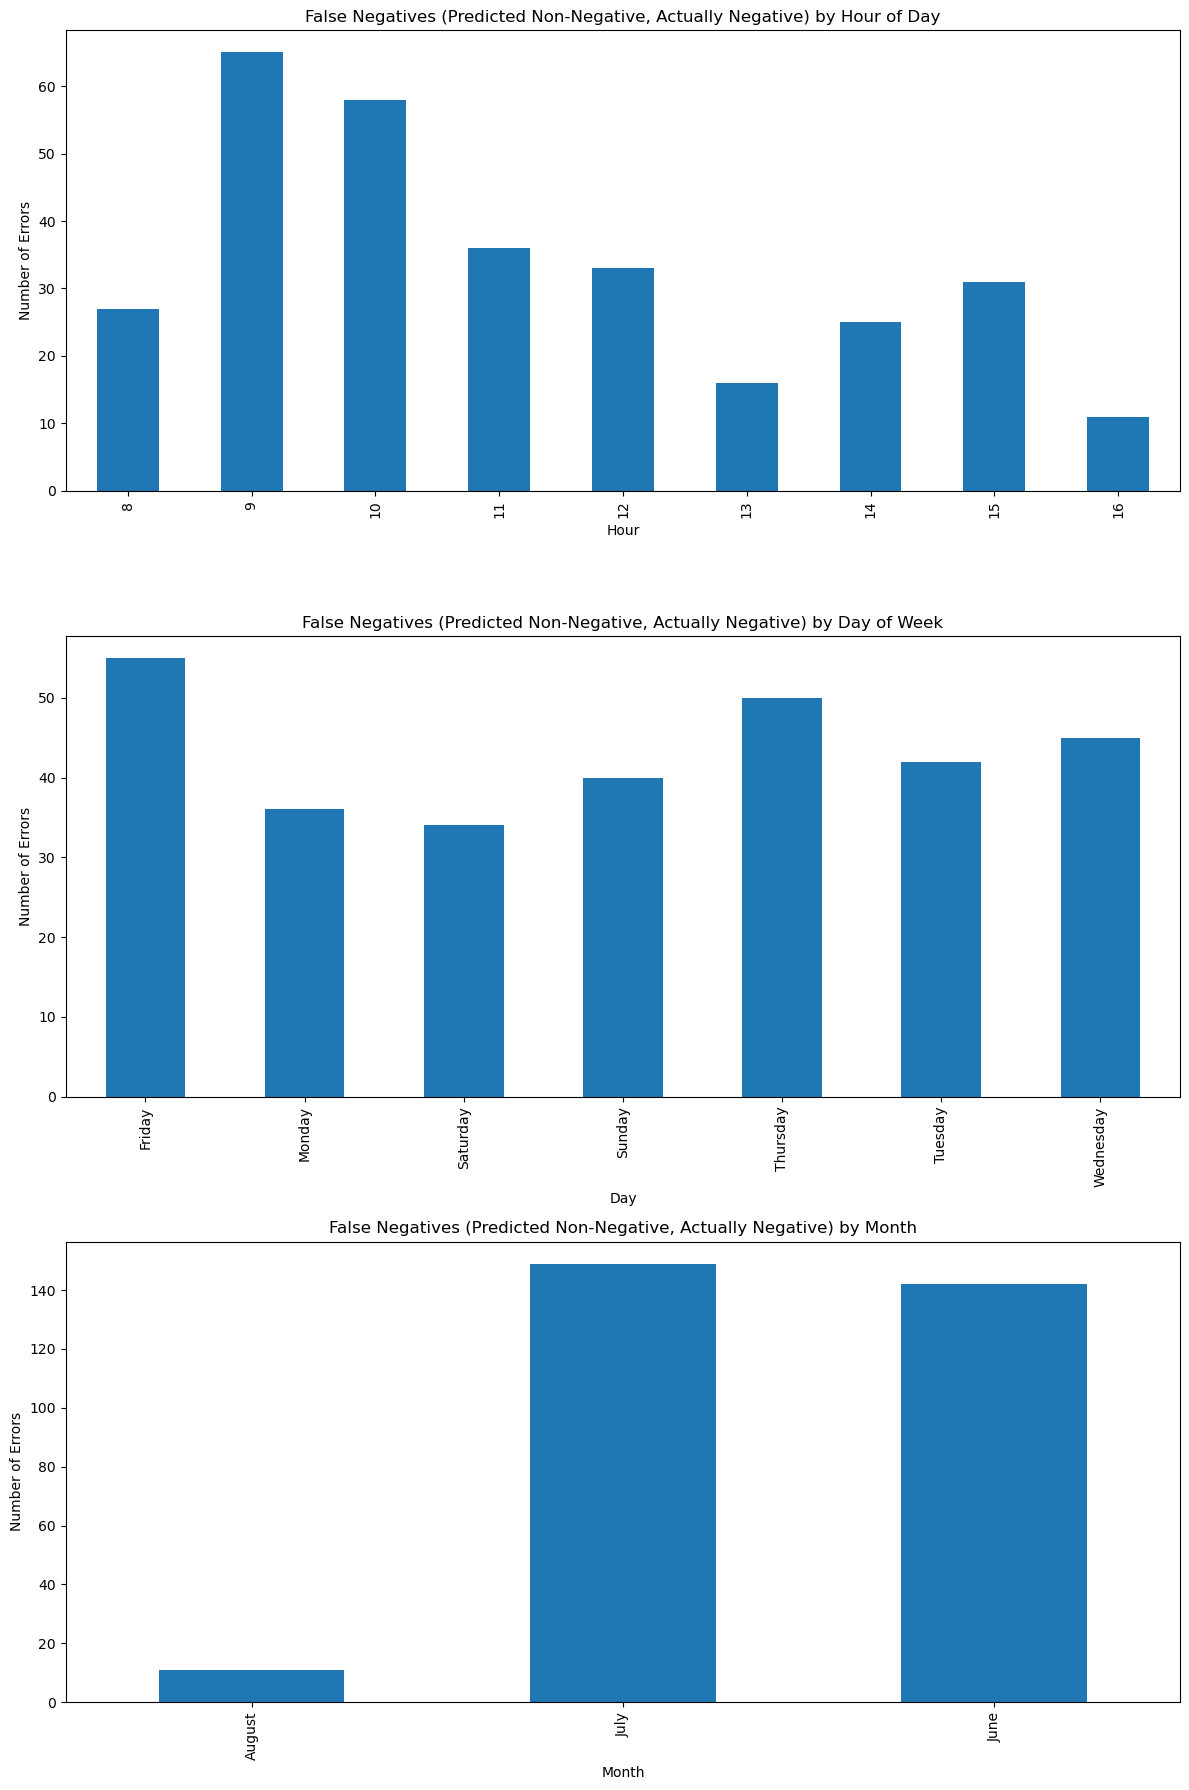


Details of False Positive samples:
                     Actual   Predicted
date                                   
2024-06-02 14:30:00   32.18   -5.569089
2024-06-03 14:15:00    0.00   -1.654877
2024-06-04 13:45:00   34.75   -6.315381
2024-06-04 15:10:00   59.85   -1.375334
2024-06-05 09:15:00   48.75 -133.029160
...                     ...         ...
2024-08-01 15:15:00   39.48  -13.020226
2024-08-02 13:00:00    6.33   -8.529709
2024-08-02 13:40:00    5.42   -5.130209
2024-08-03 08:50:00   24.48   -0.017054
2024-08-03 15:00:00   34.75   -9.132285

[160 rows x 2 columns]

Details of False Negative samples:
                     Actual  Predicted
date                                  
2024-06-02 09:15:00  -18.89  21.596407
2024-06-03 10:00:00  -18.89  25.341612
2024-06-03 10:05:00  -18.89   0.054692
2024-06-04 09:55:00  -10.50  29.581963
2024-06-04 10:00:00  -18.89   7.828574
...                     ...        ...
2024-08-02 12:20:00  -10.00   5.202120
2024-08-02 13:20:00  -18.89   5.8

In [258]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_negative_price_prediction_errors(df):
    # 將實際值和預測值轉換為二元類別（負價為1，非負價為0）
    df['Actual_Binary'] = (df['Actual'] < 0).astype(int)
    df['Predicted_Binary'] = (df['Predicted'] < 0).astype(int)
    
    # 識別錯誤預測
    df['Misclassified'] = df['Actual_Binary'] != df['Predicted_Binary']
    
    # 提取錯誤預測的樣本
    errors = df[df['Misclassified']]
    
    # 分類錯誤類型
    false_positives = errors[(errors['Actual_Binary'] == 0) & (errors['Predicted_Binary'] == 1)]
    false_negatives = errors[(errors['Actual_Binary'] == 1) & (errors['Predicted_Binary'] == 0)]
    
    # 時間統計函數
    def time_statistics(data, error_type):
        by_hour = data.groupby(data.index.hour).size()
        by_day = data.groupby(data.index.day_name()).size()
        by_month = data.groupby(data.index.month_name()).size()
        
        print(f"\n{error_type} by hour of day:")
        print(by_hour)
        print(f"\n{error_type} by day of week:")
        print(by_day)
        print(f"\n{error_type} by month:")
        print(by_month)
        
        # 繪製圖表
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))
        
        by_hour.plot(kind='bar', ax=ax1)
        ax1.set_title(f'{error_type} by Hour of Day')
        ax1.set_xlabel('Hour')
        ax1.set_ylabel('Number of Errors')
        
        by_day.plot(kind='bar', ax=ax2)
        ax2.set_title(f'{error_type} by Day of Week')
        ax2.set_xlabel('Day')
        ax2.set_ylabel('Number of Errors')
        
        by_month.plot(kind='bar', ax=ax3)
        ax3.set_title(f'{error_type} by Month')
        ax3.set_xlabel('Month')
        ax3.set_ylabel('Number of Errors')
        
        plt.tight_layout()
        plt.show()
    
    # 進行時間統計
    time_statistics(false_positives, "False Positives (Predicted Negative, Actually Non-Negative)")
    time_statistics(false_negatives, "False Negatives (Predicted Non-Negative, Actually Negative)")
    
    # 打印錯誤樣本的詳細信息
    print("\nDetails of False Positive samples:")
    print(false_positives[['Actual', 'Predicted']])
    
    print("\nDetails of False Negative samples:")
    print(false_negatives[['Actual', 'Predicted']])
    
    return false_positives, false_negatives

# 假設 results_df 已經包含 'Actual' 和 'Predicted' 列，且索引是時間戳
false_positives, false_negatives = analyze_negative_price_prediction_errors(results_df)

# 打印總體錯誤統計
print(f"\nTotal number of False Positives: {len(false_positives)}")
print(f"Total number of False Negatives: {len(false_negatives)}")